In [1]:
import scipy.io
import os
from scipy.interpolate import interp1d
from scipy import signal
import numpy as np
import pylab as plt
import pandas as pd
import xarray as xr
# from isqg import *
from numpy import *
from pylab import *
import gsw
from xrft import detrend
import xrft
import imageio
from IPython.display import Video
from matplotlib.colorbar import ColorbarBase
from scipy.signal import convolve2d
from geopy.distance import geodesic
from scipy import stats
from scipy.ndimage import binary_dilation




/home/tchonang/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:

def lonlat2km(lon_orig, lat_orig, lon, lat):
    """
    Convert longitude/latitude pairs to distances (km) east and north of a reference longitude/latitude point.

    Inputs:
    lon_orig: Reference longitude (degrees).
    lat_orig: Reference latitude (degrees).
    lon: Longitude scalar or array (degrees).
    lat: Latitude scalar or array (degrees).

    Outputs:
    east: Distance east from the reference point (km).
    north: Distance north from the reference point (km).
    """
    con = np.radians(lat_orig)
    ymetr = 111132.92 - 559.82 * np.cos(2 * con) + 1.175 * np.cos(4 * con) - 0.0023 * np.cos(6 * con)
    xmetr = 111412.84 * np.cos(con) - 93.50 * np.cos(3 * con) + 0.0118 * np.cos(5 * con)
    east = (lon - lon_orig) * xmetr / 1000
    north = (lat - lat_orig) * ymetr / 1000

    return east, north

def compute_spectrum(data, data_obs, lon, lat, tracks, lnk=124):
    """
    Compute the power spectrum for the given data.

    Parameters:
    data (numpy.ndarray): The primary data array (time, lines, pixels).
    data_obs (numpy.ndarray): The observed data array (time, lines, pixels).
    data_diff (numpy.ndarray): The difference data array (time, lines, pixels).
    lon (numpy.ndarray): Longitude values corresponding to the data.
    lat (numpy.ndarray): Latitude values corresponding to the data.
    tracks (numpy.ndarray): Array of track indices to process.
    lnk (int): Length of k (default is 124).

    Returns:
    dict: A dictionary containing the power spectra and wavenumbers.
    """
    ind_time = data.shape[0]  # Number of time indices
    data_diff = data_obs - data

    # Initialize arrays to store interpolated power spectra
    PI = np.full((ind_time, lnk, len(tracks)), np.nan)
    PI_obs = PI.copy()
    PI_diff = PI.copy()

    # Initialize lists to store wavenumber and power
    K, P, P_obs, P_diff = [], [], [], []

    for iti, ti in enumerate(np.arange(ind_time)):  # Loop over each time index
        # print(f"{iti+1}/{ind_time}")  # Show progress

        for itr, tr in enumerate(tracks):  # Loop over each track
            tns = data[ti, :, tr]  # Get transect of data for current time and track
            tns_obs = data_obs[ti, :, tr]  # Get observed data transect
            tns_diff = data_diff[ti, :, tr]  # Get difference data transect

            # Calculate distances between points
            et, nt = lonlat2km(lon[1:, tr], lat[1:, tr], lon[:-1, tr], lat[:-1, tr])
            distkm = np.sqrt(et**2 + nt**2)

            # Calculate 'dx' using the mean of the mode value for 'distkm'
            filtered_distkm = distkm[~np.isnan(distkm)]
            mode_value = np.nanmean(stats.mode(filtered_distkm, keepdims=True).mode)
            dx = mode_value

            # Handle NaN values
            consecutive_nans = np.where(np.isnan(tns))[0]
            consecutive_diff = np.diff(consecutive_nans) - 1
            if np.sum(np.isnan(tns)) <= 3:  # If there are 3 or fewer consecutive NaN values
                # Interpolate NaN values
                nan_indices = np.where(np.isnan(tns))[0]
                valid_indices = np.where(~np.isnan(tns))[0]
                tns[nan_indices] = np.interp(nan_indices, valid_indices, tns[valid_indices])
                tns_obs[nan_indices] = np.interp(nan_indices, valid_indices, tns_obs[valid_indices])
                tns_diff[nan_indices] = np.interp(nan_indices, valid_indices, tns_diff[valid_indices])
            else:
                # Handle larger sections with NaN values
                consecutive_sections = np.split(consecutive_nans, np.where(consecutive_diff >= 3)[0] + 1)
                for section in consecutive_sections:
                    if len(section) <= 3:  # If section has 3 or fewer NaNs
                        nan_indices = section
                        valid_indices = np.where(~np.isnan(tns))[0]
                        tns[nan_indices] = np.interp(nan_indices, valid_indices, tns[valid_indices])
                        tns_obs[nan_indices] = np.interp(nan_indices, valid_indices, tns_obs[valid_indices])
                        tns_diff[nan_indices] = np.interp(nan_indices, valid_indices, tns_diff[valid_indices])

            if np.sum(np.isnan(tns)) != len(tns):  # If not all values are NaNs
                # Find the longest continuous section without NaNs
                F = np.where(np.isnan(np.concatenate(([np.nan], tns, [np.nan]))))[0]
                D = np.diff(F) - 2
                L = np.argmax(D)
                M = D[L]
                VV = tns[F[L]:F[L] + M]
                VV_obs = tns_obs[F[L]:F[L] + M]
                VV_diff = tns_diff[F[L]:F[L] + M]

                if len(VV) > 100:  # Ensure sufficient data length
                    Nx = len(VV)  # Length of transect

                    # Remove spatial mean and detrend
                    vv = signal.detrend(VV - np.nanmean(VV))
                    vv_obs = signal.detrend(VV_obs - np.nanmean(VV_obs))
                    vv_diff = signal.detrend(VV_diff - np.nanmean(VV_diff))

                    win = np.hanning(Nx)
                    vw = vv * win
                    vw_obs = vv_obs * win
                    vw_diff = vv_diff * win

                    # Compute FFT
                    Nyq_k = 1 / (2 * dx)  # Nyquist wavenumber
                    dk = 1 / (Nx * dx)  # Wavenumber increment
                    kf = np.arange(-Nyq_k, Nyq_k, dk)  # Wavenumber array
                    if kf.shape[0] > Nx:
                        kf = kf[:-1]

                    # Compute power spectra
                    p1 = np.abs(np.fft.fft(vw)) ** 2
                    p1_obs = np.abs(np.fft.fft(vw_obs)) ** 2
                    p1_diff = np.abs(np.fft.fft(vw_diff)) ** 2

                    scale = dx / Nx / np.mean(win**2)  # Rescale factor

                    pf = np.fft.fftshift(p1 * scale * 2)  # Power spectrum
                    pf_obs = np.fft.fftshift(p1_obs * scale * 2)
                    pf_diff = np.fft.fftshift(p1_diff * scale * 2)

                    # Extract positive wavenumbers
                    ki = kf[kf >= 0]
                    pi = pf[kf >= 0]
                    pi_obs = pf_obs[kf >= 0]
                    pi_diff = pf_diff[kf >= 0]

                    # Append results to lists
                    K.append(ki)
                    P.append(pi)
                    P_obs.append(pi_obs)
                    P_diff.append(pi_diff)

                    # Interpolate power spectra to uniform k-space
                    if len(ki) > 10:
                        kspace = np.linspace(0.002, ki[-1], lnk)
                        Pi = np.interp(kspace, ki, pi)
                        Pi_obs = np.interp(kspace, ki, pi_obs)
                        Pi_diff = np.interp(kspace, ki, pi_diff)

                        # Store interpolated power spectra
                        PI[iti, :len(kspace), itr] = Pi
                        PI_obs[iti, :len(kspace), itr] = Pi_obs
                        PI_diff[iti, :len(kspace), itr] = Pi_diff

    # Return results as a dictionary
    return {
        "K": K,
        "P": P,
        "kspace": kspace,
        "P_obs": P_obs,
        "P_diff": P_diff,
        "PI": PI,
        "PI_obs": PI_obs,
        "PI_diff": PI_diff
    }


In [175]:
def determine_window_size_alongtrack(lat, lon, desired_resolution_km):
    numlines, numpixels = lat.shape
    
    # Calculate distances between adjacent points along the track
    distances_alongtrack = [
        geodesic((lat[i, 0], lon[i, 0]), (lat[i+1, 0], lon[i+1, 0])).km
        for i in range(numlines - 1)
    ]
    
    # Average distance between points along the track
    avg_distance_alongtrack = np.mean(distances_alongtrack)
    
    # Convert the desired resolution into the number of grid points
    dy = int(desired_resolution_km / avg_distance_alongtrack)
    
    return dy

def apply_hanning_alongtrack(data, lat, lon, desired_resolution_km):
    dy = determine_window_size_alongtrack(lat, lon, desired_resolution_km)
    
    window_alongtrack = np.hanning(dy)
    window_alongtrack /= window_alongtrack.sum()  # Normalize the window to preserve data amplitude

    # Pad data to minimize edge effects
    pad_width_alongtrack = dy // 2
    data_padded = np.pad(data, ((pad_width_alongtrack, pad_width_alongtrack), (0, 0)), mode='constant', constant_values=0)#, mode='reflect')

    # Handle NaNs by treating them as zero (influence can be limited by normalizing the window)
    nan_mask = np.isnan(data_padded)
    data_padded[nan_mask] = 0

    # Apply 1D convolution along the along-track dimension
    filtered_data = np.apply_along_axis(lambda m: np.convolve(m, window_alongtrack, mode='valid'), axis=0, arr=data_padded)

    # Correct the NaN influence by reapplying the nan_mask
    nan_mask = nan_mask.astype(float)
    normalization = np.apply_along_axis(lambda m: np.convolve(m, window_alongtrack, mode='valid'), axis=0, arr=1 - nan_mask)
    filtered_data /= normalization
    nan_result_mask = normalization == 0
    filtered_data[nan_result_mask] = np.nan

    return filtered_data

In [4]:
def determine_window_sizes(lat, lon, desired_resolution_km):
    numlines, numpixels = lat.shape
    
    # Calculate distances between adjacent points
    distances_alongtrack = [
        geodesic((lat[i, 0], lon[i, 0]), (lat[i+1, 0], lon[i+1, 0])).km
        for i in range(numlines - 1)
    ]
    distances_crosstrack = [
        geodesic((lat[0, j], lon[0, j]), (lat[0, j+1], lon[0, j+1])).km
        for j in range(numpixels - 1)
    ]
    
    # Average distance between points
    avg_distance_alongtrack = np.mean(distances_alongtrack)
    avg_distance_crosstrack = np.mean(distances_crosstrack)
    
    # Convert the desired resolution into the number of grid points
    dy = int(desired_resolution_km / avg_distance_alongtrack)
    dx = int(desired_resolution_km / avg_distance_crosstrack)
    
    return dy, dx

def apply_hanning(data, lat, lon, desired_resolution_km):
    dy, dx = determine_window_sizes(lat, lon, desired_resolution_km)
    
    window_alongtrack = np.hanning(dy)
    window_crosstrack = np.hanning(dx)
    window = window_alongtrack[:, None] * window_crosstrack[None, :]  # Create a 2D window
    window /= window.sum()  # Normalize the window to preserve data amplitude

    # Pad data to minimize edge effects
    pad_width_alongtrack = dy // 2
    pad_width_crosstrack = dx // 2
    data_padded = np.pad(data, ((pad_width_alongtrack, pad_width_alongtrack),
                                (pad_width_crosstrack, pad_width_crosstrack)), mode='reflect')

    # Handle NaNs by treating them as zero (influence can be limited by normalizing the window)
    nan_mask = np.isnan(data_padded)
    data_padded[nan_mask] = 0
    filtered_data = convolve2d(data_padded, window, mode='valid', boundary='fill', fillvalue=0)

    # Correct the NaN influence by reapplying the nan_mask
    nan_mask = nan_mask.astype(float)
    normalization = convolve2d(1 - nan_mask, window, mode='valid', boundary='fill', fillvalue=0)
    filtered_data /= normalization
    nan_result_mask = normalization == 0
    filtered_data[nan_result_mask] = np.nan

    return filtered_data

In [5]:
def remove_adjacent_nans_2d(data):
    # Make a copy of the data to avoid modifying the original array
    modified_data = data.copy()
    
    # Step 1: Identify NaN values
    nan_mask = np.isnan(modified_data)
    
    # Step 2: Expand the mask to include neighbors (4-connectivity)
    structure = np.array([[0, 1, 0],
                          [0, 1, 0],
                          [0, 1, 0]])  # left and right only 
    
    expanded_nan_mask = binary_dilation(nan_mask, structure=structure)
    
    # Step 3: Set the neighboring cells to NaN
    modified_data[expanded_nan_mask] = np.nan
    
    return modified_data

def remove_adjacent_nans_3d(data_3d):
    # Make a copy of the 3D data to avoid modifying the original array
    modified_data_3d = data_3d.copy()
    
    # Loop over the first dimension (n)
    for i in range(data_3d.shape[0]):
        # Apply the 2D NaN removal function to each (m, r) slice
        modified_data_3d[i, :, :] = remove_adjacent_nans_2d(modified_data_3d[i, :, :])
    
    return modified_data_3d

In [6]:
def apply_hanning_ignore_nans(data, lat, lon, desired_resolution_km):
    # Step 1: Determine window sizes based on desired resolution and location
    dy, dx = determine_window_sizes(lat, lon, desired_resolution_km)
    
    # Step 2: Create the 2D Hanning window
    window_alongtrack = np.hanning(dy)
    window_crosstrack = np.hanning(dx)
    window = window_alongtrack[:, None] * window_crosstrack[None, :]  # 2D window
    window /= window.sum()  # Normalize to preserve data amplitude
    
    # Step 3: Handle NaNs by masking them (NaNs are set to zero temporarily)
    nan_mask = np.isnan(data)
    data_masked = np.where(nan_mask, 0, data)  # Set NaNs to 0 to ignore them in the filter
    
    # Step 4: Apply the Hanning window using convolution
    filtered_data = convolve2d(data_masked, window, mode='same', boundary='wrap')
    
    # Step 5: Compute normalization to adjust for NaNs (how many valid points contribute to each region)
    valid_data_mask = np.where(nan_mask, 0, 1)  # Set NaNs to 0, valid points to 1
    normalization = convolve2d(valid_data_mask, window, mode='same', boundary='wrap')
    
    # Step 6: Avoid division by zero in normalization
    normalization[normalization == 0] = np.nan  # Set normalization to NaN where there were no valid points
    
    # Step 7: Normalize the filtered data
    filtered_data /= normalization
    
    # Step 8: Reapply NaN mask to the final result
    filtered_data[nan_mask] = np.nan

    return filtered_data

In [7]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Difference in the coordinates
    dlon = lon2 - lon1

    # Primary calculation
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

    # Bearing converted from radians to degrees
    initial_bearing = np.arctan2(x, y)
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [8]:
def compute_along_track_directions(latitudes, longitudes):
    bearings = []
    for i in range(len(latitudes) - 1):
        bearing = calculate_bearing(latitudes[i], longitudes[i], latitudes[i + 1], longitudes[i + 1])
        bearings.append(bearing)
    return bearings

def compute_average_bearing(bearings):
    # Convert bearings to radians for circular mean calculation
    radian_bearings = np.radians(bearings)
    average_bearing_radians = np.arctan2(np.mean(np.sin(radian_bearings)), np.mean(np.cos(radian_bearings)))
    average_bearing_degrees = np.degrees(average_bearing_radians) % 360
    return average_bearing_degrees


In [9]:
# def rotate_coordinates(u_local, v_local, theta_deg):
#     theta_rad = np.radians(theta_deg)
#     u_geo = u_local * np.cos(theta_rad) - v_local * np.sin(theta_rad)
#     v_geo = u_local * np.sin(theta_rad) + v_local * np.cos(theta_rad)
#     return u_geo, v_geo
def rotate_coordinates(u_local, v_local, theta_deg):
    theta_rad = np.radians(theta_deg)
    u_geo = u_local * np.cos(theta_rad) + v_local * np.sin(theta_rad)  # Adjusted signs
    v_geo = u_local * np.sin(theta_rad) + v_local * np.cos(theta_rad)  # Adjusted signs
    return u_geo, v_geo

def compute_geostrophic_velocities_through_time(time, lat, lon, ssh):
    """
    Compute geostrophic velocities from SSH data and project them to northward and eastward components.
    
    Parameters:
    lat (numpy.ndarray): Latitude values, 2D array (num_lines, num_pixels).
    lon (numpy.ndarray): Longitude values, 2D array (num_lines, num_pixels).
    ssh (numpy.ndarray): Sea surface height values, either 2D array (num_lines, num_pixels) or 3D array (time, num_lines, num_pixels).
    
    Returns:
    xarray.Dataset: Dataset enriched with geostrophic velocity components 'u_g', 'v_g', 'v_n' (northward), and 'v_e' (eastward).
    """
    # Ensure input arrays have the correct dimensions
    assert lat.shape == lon.shape, "Latitude and longitude arrays must have the same shape."
    
    if ssh.ndim == 2:
        ssh = np.expand_dims(ssh, axis=0)  # Add time dimension if only a single time slice is provided
    
    assert ssh.shape[1:] == lat.shape, "SSH spatial dimensions must match latitude and longitude dimensions."

    # Constants
    g = 9.81  # Acceleration due to gravity in m/s^2
    omega = 7.2921e-5  # Earth's rotation rate in rad/s
    earth_radius = 6371000  # Earth radius in meters

    # Initialize arrays for gradients and velocities
    grad_ssh_x = np.empty_like(ssh)
    grad_ssh_y = np.empty_like(ssh)
    u_g = np.full_like(ssh,np.nan)
    v_g = np.full_like(ssh,np.nan)
    v_n = np.empty_like(ssh)
    v_e = np.empty_like(ssh)

    # Calculate the angle theta for rotation
    dlon = np.gradient(lon, axis=1)
    dlat = np.gradient(lat, axis=0)
    theta_deg = np.arctan2(dlat, dlon) * 180 / np.pi

    # Loop through each time step
    for t in range(ssh.shape[0]):
        # Create xarray.Dataset for the current time step
        ds = xr.Dataset(
            {
                'SSH': (['num_lines', 'num_pixels'], ssh[t])
            },
            coords={
                'latitude': (['num_lines', 'num_pixels'], lat),
                'longitude': (['num_lines', 'num_pixels'], lon)
            }
        )

        # Calculate the Coriolis parameter
        ds['f'] = 2 * omega * np.sin(np.deg2rad(ds.latitude))

        # Calculate spatial deltas in meters for longitude and latitude
        # Longitude
        longitude_diff = np.diff(ds.longitude, axis=1)
        longitude_diff[longitude_diff > 180] -= 360  # Correct for dateline jump
        longitude_diff[longitude_diff < -180] += 360
        longitude_diff_extended = np.pad(longitude_diff, ((0, 0), (0, 1)), mode='edge')
        dx = xr.DataArray(
            (earth_radius * np.cos(np.deg2rad(ds.latitude)) * (np.pi / 180)) * longitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Latitude
        latitude_diff = np.diff(ds.latitude, axis=0)
        latitude_diff_extended = np.pad(latitude_diff, ((0, 1), (0, 0)), mode='edge')
        dy = xr.DataArray(
            (earth_radius * np.pi / 180) * latitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Compute gradients of SSH
        ds['grad_ssh_x'] = xr.DataArray(np.gradient(ds.SSH, axis=1) / dx, dims=('num_lines', 'num_pixels'), coords=ds.SSH.coords)
        ds['grad_ssh_y'] = xr.DataArray(np.gradient(ds.SSH, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSH.coords)

        # Calculate geostrophic velocities
        u_g[t] = -g / ds['f'] * ds['grad_ssh_y']
        v_g[t] = g / ds['f'] * ds['grad_ssh_x']

        # Rotate velocities to northward and eastward components
        v_n[t], v_e[t] = rotate_coordinates(u_g[t], v_g[t], theta_deg)

    # Create the final xarray.Dataset with all time steps
    ds_final = xr.Dataset(
        {
            'SSH': (['time', 'num_lines', 'num_pixels'], ssh),
            'u_g': (['time', 'num_lines', 'num_pixels'], u_g),
            'v_g': (['time', 'num_lines', 'num_pixels'], v_g),
            'v_n': (['time', 'num_lines', 'num_pixels'], v_n),
            'v_e': (['time', 'num_lines', 'num_pixels'], v_e),
            'grad_ssh_x': (['time', 'num_lines', 'num_pixels'], grad_ssh_x),
            'grad_ssh_y': (['time', 'num_lines', 'num_pixels'], grad_ssh_y)
        },
        coords={
            'latitude': (['num_lines', 'num_pixels'], lat),
            'longitude': (['num_lines', 'num_pixels'], lon),
            'time': (['time'], time)
        }
    )

    return ds_final


In [10]:
import numpy as np
import xarray as xr

def compute_geostrophic_velocities_and_eke_through_time(time, lat, lon, ssha, ssha_noiseless):
    """
    Compute geostrophic velocities and EKE from SSH data for both noisy and noiseless SSH.
    
    Parameters:
    lat (numpy.ndarray): Latitude values, 2D array (num_lines, num_pixels).
    lon (numpy.ndarray): Longitude values, 2D array (num_lines, num_pixels).
    ssha (numpy.ndarray): Noisy sea surface height values, 3D array (time, num_lines, num_pixels).
    ssha_noiseless (numpy.ndarray): Noiseless sea surface height values, 3D array (time, num_lines, num_pixels).
    
    Returns:
    xarray.Dataset: Dataset enriched with geostrophic velocity components 'u_g', 'v_g', 'u_g_noiseless', 'v_g_noiseless', 'eke', and 'eke_noiseless'.
    """
    # Ensure input arrays have the correct dimensions
    assert lat.shape == lon.shape, "Latitude and longitude arrays must have the same shape."
    assert ssha.shape == ssha_noiseless.shape, "SSHA and SSHA_noiseless arrays must have the same shape."
    assert ssha.shape[1:] == lat.shape, "SSH spatial dimensions must match latitude and longitude dimensions."

    # Constants
    g = 9.81  # Acceleration due to gravity in m/s^2
    omega = 7.2921e-5  # Earth's rotation rate in rad/s
    earth_radius = 6371000  # Earth radius in meters

    # Initialize arrays for gradients, velocities, and EKE
    grad_ssh_x = np.full_like(ssha,np.nan)
    grad_ssh_y = np.full_like(ssha,np.nan)
    u_g = np.full_like(ssha,np.nan)
    v_g = np.full_like(ssha,np.nan)
    eke = np.full_like(ssha,np.nan)

    grad_ssh_x_noiseless = np.full_like(ssha_noiseless,np.nan)
    grad_ssh_y_noiseless = np.full_like(ssha_noiseless,np.nan)
    u_g_noiseless = np.full_like(ssha_noiseless,np.nan)
    v_g_noiseless = np.full_like(ssha_noiseless,np.nan)
    eke_noiseless = np.full_like(ssha_noiseless,np.nan)

    # Loop through each time step
    for t in range(ssha.shape[0]):
        # Create xarray.Dataset for the current time step
        ds = xr.Dataset(
            {
                'SSHA': (['num_lines', 'num_pixels'], ssha[t]),
                'SSHA_noiseless': (['num_lines', 'num_pixels'], ssha_noiseless[t])
            },
            coords={
                'latitude': (['num_lines', 'num_pixels'], lat),
                'longitude': (['num_lines', 'num_pixels'], lon)
            }
        )

        # Calculate the Coriolis parameter
        ds['f'] = 2 * omega * np.sin(np.deg2rad(ds.latitude))

        # Calculate spatial deltas in meters for longitude and latitude
        # Longitude
        longitude_diff = np.diff(ds.longitude, axis=1)
        longitude_diff[longitude_diff > 180] -= 360  # Correct for dateline jump
        longitude_diff[longitude_diff < -180] += 360
        longitude_diff_extended = np.pad(longitude_diff, ((0, 0), (0, 1)), mode='edge')
        dx = xr.DataArray(
            (earth_radius * np.cos(np.deg2rad(ds.latitude)) * (np.pi / 180)) * longitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Latitude
        latitude_diff = np.diff(ds.latitude, axis=0)
        latitude_diff_extended = np.pad(latitude_diff, ((0, 1), (0, 0)), mode='edge')
        dy = xr.DataArray(
            (earth_radius * np.pi / 180) * latitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Compute gradients of SSH for both noisy and noiseless SSH
        ds['grad_ssh_x'] = xr.DataArray(np.gradient(ds.SSHA, axis=1) / dx, dims=('num_lines', 'num_pixels'), coords=ds.SSHA.coords)
        ds['grad_ssh_y'] = xr.DataArray(np.gradient(ds.SSHA, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSHA.coords)

        ds['grad_ssh_x_noiseless'] = xr.DataArray(np.gradient(ds.SSHA_noiseless, axis=1) / dx, dims=('num_lines', 'num_pixels'), coords=ds.SSHA_noiseless.coords)
        ds['grad_ssh_y_noiseless'] = xr.DataArray(np.gradient(ds.SSHA_noiseless, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSHA_noiseless.coords)
        
        grad_ssh_x[t] = ds['grad_ssh_x']
        grad_ssh_y[t] = ds['grad_ssh_y']
        
        grad_ssh_x_noiseless[t] = ds['grad_ssh_x_noiseless']
        grad_ssh_y_noiseless[t] = ds['grad_ssh_y_noiseless']

        # Calculate geostrophic velocities for both noisy and noiseless SSH
        u_g[t] = -g / ds['f'] * ds['grad_ssh_y']
        v_g[t] = g / ds['f'] * ds['grad_ssh_x']

        u_g_noiseless[t] = -g / ds['f'] * ds['grad_ssh_y_noiseless']
        v_g_noiseless[t] = g / ds['f'] * ds['grad_ssh_x_noiseless']

    # Calculate mean geostrophic velocities
    u_g_mean = np.nanmean(u_g, axis=0)
    v_g_mean = np.nanmean(v_g, axis=0)
    u_g_noiseless_mean = np.nanmean(u_g_noiseless, axis=0)
    v_g_noiseless_mean = np.nanmean(v_g_noiseless, axis=0)

    # Compute deviations from the mean
    u_g_prime = u_g - u_g_mean
    v_g_prime = v_g - v_g_mean
    u_g_noiseless_prime = u_g_noiseless - u_g_noiseless_mean
    v_g_noiseless_prime = v_g_noiseless - v_g_noiseless_mean

    # Calculate EKE for both noisy and noiseless SSH
    eke = 0.5 * (u_g_prime**2 + v_g_prime**2)
    eke_noiseless = 0.5 * (u_g_noiseless_prime**2 + v_g_noiseless_prime**2)

    # Create the final xarray.Dataset with all time steps
    ds_final = xr.Dataset(
        {
            'SSHA': (['time', 'num_lines', 'num_pixels'], ssha),
            'SSHA_noiseless': (['time', 'num_lines', 'num_pixels'], ssha_noiseless),
            'u_g': (['time', 'num_lines', 'num_pixels'], u_g),
            'v_g': (['time', 'num_lines', 'num_pixels'], v_g),
            'u_g_noiseless': (['time', 'num_lines', 'num_pixels'], u_g_noiseless),
            'v_g_noiseless': (['time', 'num_lines', 'num_pixels'], v_g_noiseless),
            'grad_ssh_x': (['time', 'num_lines', 'num_pixels'], grad_ssh_x),
            'grad_ssh_y': (['time', 'num_lines', 'num_pixels'], grad_ssh_y),
            'grad_ssh_x_noiseless': (['time', 'num_lines', 'num_pixels'], grad_ssh_x_noiseless),
            'grad_ssh_y_noiseless': (['time', 'num_lines', 'num_pixels'], grad_ssh_y_noiseless),
            'eke': (['time', 'num_lines', 'num_pixels'], eke),
            'eke_noiseless': (['time', 'num_lines', 'num_pixels'], eke_noiseless)
        },
        coords={
            'latitude': (['num_lines', 'num_pixels'], lat),
            'longitude': (['num_lines', 'num_pixels'], lon),
            'time': (['time'], time)
        }
    )

    return ds_final

In [11]:
def project_to_east_north(u_g, v_g, theta):
    """
    Project cross-track (u_g) and along-track (v_g) velocities onto eastward and northward directions.
    
    :param u_g: Cross-track velocity component
    :param v_g: Along-track velocity component
    :param theta: Angle of the SWOT track with the eastward direction in radians
    :return: (u_east, v_north) - Eastward and Northward velocity components
    """
    # Convert angle to radians if needed
    if theta > 2 * np.pi:
        theta = np.deg2rad(theta)
    u_east = v_g * np.cos(theta) - u_g * np.sin(theta)
    v_north = v_g * np.sin(theta) + u_g * np.cos(theta)
    
    return u_east, v_north

def compute_geostrophic_velocities_and_eke_through_time(time, lat, lon, ssha, ssha_noiseless, theta):
    """
    Compute geostrophic velocities and EKE from SSH data for both noisy and noiseless SSH, and project velocities onto eastward and northward directions.
    
    Parameters:
    lat (numpy.ndarray): Latitude values, 2D array (num_lines, num_pixels).
    lon (numpy.ndarray): Longitude values, 2D array (num_lines, num_pixels).
    ssha (numpy.ndarray): Noisy sea surface height values, 3D array (time, num_lines, num_pixels).
    ssha_noiseless (numpy.ndarray): Noiseless sea surface height values, 3D array (time, num_lines, num_pixels).
    theta (float): Angle of the SWOT track with the eastward direction in radians.
    
    Returns:
    xarray.Dataset: Dataset enriched with geostrophic velocity components 'u_g', 'v_g', 'u_g_noiseless', 'v_g_noiseless', 'eke', and 'eke_noiseless'.
    """
    # Ensure input arrays have the correct dimensions
    assert lat.shape == lon.shape, "Latitude and longitude arrays must have the same shape."
    assert ssha.shape == ssha_noiseless.shape, "SSHA and SSHA_noiseless arrays must have the same shape."
    assert ssha.shape[1:] == lat.shape, "SSH spatial dimensions must match latitude and longitude dimensions."

    # Constants
    g = 9.81  # Acceleration due to gravity in m/s^2
    omega = 7.2921e-5  # Earth's rotation rate in rad/s
    earth_radius = 6371000  # Earth radius in meters

    # Initialize arrays for gradients, velocities, and EKE
    grad_ssh_x = np.full_like(ssha, np.nan)
    grad_ssh_y = np.full_like(ssha, np.nan)
    u_g = np.full_like(ssha, np.nan)
    v_g = np.full_like(ssha, np.nan)
    u_east = np.full_like(ssha, np.nan)
    v_north = np.full_like(ssha, np.nan)
    eke = np.full_like(ssha, np.nan)

    grad_ssh_x_noiseless = np.full_like(ssha_noiseless, np.nan)
    grad_ssh_y_noiseless = np.full_like(ssha_noiseless, np.nan)
    u_g_noiseless = np.full_like(ssha_noiseless, np.nan)
    v_g_noiseless = np.full_like(ssha_noiseless, np.nan)
    u_east_noiseless = np.full_like(ssha_noiseless, np.nan)
    v_north_noiseless = np.full_like(ssha_noiseless, np.nan)
    eke_noiseless = np.full_like(ssha_noiseless, np.nan)

    # Loop through each time step
    for t in range(ssha.shape[0]):
        # Create xarray.Dataset for the current time step
        ds = xr.Dataset(
            {
                'SSHA': (['num_lines', 'num_pixels'], ssha[t]),
                'SSHA_noiseless': (['num_lines', 'num_pixels'], ssha_noiseless[t])
            },
            coords={
                'latitude': (['num_lines', 'num_pixels'], lat),
                'longitude': (['num_lines', 'num_pixels'], lon)
            }
        )

        # Calculate the Coriolis parameter
        ds['f'] = 2 * omega * np.sin(np.deg2rad(ds.latitude))

        # Calculate spatial deltas in meters for longitude and latitude
        # Longitude
        longitude_diff = np.diff(ds.longitude, axis=1)
        longitude_diff[longitude_diff > 180] -= 360  # Correct for dateline jump
        longitude_diff[longitude_diff < -180] += 360
        longitude_diff_extended = np.pad(longitude_diff, ((0, 0), (0, 1)), mode='edge')
        dx = xr.DataArray(
            (earth_radius * np.cos(np.deg2rad(ds.latitude)) * (np.pi / 180)) * longitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Latitude
        latitude_diff = np.diff(ds.latitude, axis=0)
        latitude_diff_extended = np.pad(latitude_diff, ((0, 1), (0, 0)), mode='edge')
        dy = xr.DataArray(
            (earth_radius * np.pi / 180) * latitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Compute gradients of SSH for both noisy and noiseless SSH
        ds['grad_ssh_x'] = xr.DataArray(np.gradient(ds.SSHA, axis=1) / dx, dims=('num_lines', 'num_pixels'), coords=ds.SSHA.coords)
        ds['grad_ssh_y'] = xr.DataArray(np.gradient(ds.SSHA, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSHA.coords)

        ds['grad_ssh_x_noiseless'] = xr.DataArray(np.gradient(ds.SSHA_noiseless, axis=1) / dx, dims=('num_lines', 'num_pixels'), coords=ds.SSHA_noiseless.coords)
        ds['grad_ssh_y_noiseless'] = xr.DataArray(np.gradient(ds.SSHA_noiseless, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSHA_noiseless.coords)
        
        grad_ssh_x[t] = ds['grad_ssh_x']
        grad_ssh_y[t] = ds['grad_ssh_y']
        
        grad_ssh_x_noiseless[t] = ds['grad_ssh_x_noiseless']
        grad_ssh_y_noiseless[t] = ds['grad_ssh_y_noiseless']

        # Calculate geostrophic velocities for both noisy and noiseless SSH
        u_g[t] = -g / ds['f'] * ds['grad_ssh_y']
        v_g[t] = g / ds['f'] * ds['grad_ssh_x']

        u_g_noiseless[t] = -g / ds['f'] * ds['grad_ssh_y_noiseless']
        v_g_noiseless[t] = g / ds['f'] * ds['grad_ssh_x_noiseless']

        # Project geostrophic velocities onto eastward and northward directions
        u_east[t], v_north[t] = project_to_east_north(u_g[t], v_g[t], theta)
        u_east_noiseless[t], v_north_noiseless[t] = project_to_east_north(u_g_noiseless[t], v_g_noiseless[t], theta)

    # Calculate mean geostrophic velocities
    u_g_mean = np.nanmean(u_g, axis=0)
    v_g_mean = np.nanmean(v_g, axis=0)
    u_g_noiseless_mean = np.nanmean(u_g_noiseless, axis=0)
    v_g_noiseless_mean = np.nanmean(v_g_noiseless, axis=0)

    # Compute deviations from the mean
    u_g_prime = u_g - u_g_mean
    v_g_prime = v_g - v_g_mean
    u_g_noiseless_prime = u_g_noiseless - u_g_noiseless_mean
    v_g_noiseless_prime = v_g_noiseless - v_g_noiseless_mean

    # Calculate EKE for both noisy and noiseless SSH
    eke = 0.5 * (u_g_prime**2 + v_g_prime**2)
    eke_noiseless = 0.5 * (u_g_noiseless_prime**2 + v_g_noiseless_prime**2)

    # Create the final xarray.Dataset with all time steps
    ds_final = xr.Dataset(
        {
            'SSHA': (['time', 'num_lines', 'num_pixels'], ssha),
            'SSHA_noiseless': (['time', 'num_lines', 'num_pixels'], ssha_noiseless),
            'u_g': (['time', 'num_lines', 'num_pixels'], u_g),
            'v_g': (['time', 'num_lines', 'num_pixels'], v_g),
            'u_g_noiseless': (['time', 'num_lines', 'num_pixels'], u_g_noiseless),
            'v_g_noiseless': (['time', 'num_lines', 'num_pixels'], v_g_noiseless),
            'grad_ssh_x': (['time', 'num_lines', 'num_pixels'], grad_ssh_x),
            'grad_ssh_y': (['time', 'num_lines', 'num_pixels'], grad_ssh_y),
            'grad_ssh_x_noiseless': (['time', 'num_lines', 'num_pixels'], grad_ssh_x_noiseless),
            'grad_ssh_y_noiseless': (['time', 'num_lines', 'num_pixels'], grad_ssh_y_noiseless),
            'eke': (['time', 'num_lines', 'num_pixels'], eke),
            'eke_noiseless': (['time', 'num_lines', 'num_pixels'], eke_noiseless),
            'u_east': (['time', 'num_lines', 'num_pixels'], u_east),
            'v_north': (['time', 'num_lines', 'num_pixels'], v_north),
            'u_east_noiseless': (['time', 'num_lines', 'num_pixels'], u_east_noiseless),
            'v_north_noiseless': (['time', 'num_lines', 'num_pixels'], v_north_noiseless)
        },
        coords={
            'latitude': (['num_lines', 'num_pixels'], lat),
            'longitude': (['num_lines', 'num_pixels'], lon),
            'time': (['time'], time)
        }
    )

    return ds_final

In [12]:
def project_to_east_north_matrix(u_g, v_g, theta_matrix):
    """
    Project cross-track (u_g) and along-track (v_g) velocities onto eastward and northward directions.
    
    :param u_g: Cross-track velocity component
    :param v_g: Along-track velocity component
    :param theta_matrix: Matrix of angles of the SWOT track with the eastward direction in radians
    :return: (u_east, v_north) - Eastward and Northward velocity components as matrices
    """
    # Convert angle to radians if needed
    if np.any(theta_matrix > 2 * np.pi):
        theta_matrix = np.deg2rad(theta_matrix)
        
    u_east = u_g * np.cos(theta_matrix) - v_g * np.sin(theta_matrix)
    v_north = u_g * np.sin(theta_matrix) + v_g * np.cos(theta_matrix)
    
    return u_east, v_north

def compute_geostrophic_velocities_and_eke_through_time(time, lat, lon, ssha, ssha_noiseless,theta):
    """
    Compute geostrophic velocities and EKE from SSH data for both noisy and noiseless SSH, and project velocities onto eastward and northward directions.
    
    Parameters:
    lat (numpy.ndarray): Latitude values, 2D array (num_lines, num_pixels).
    lon (numpy.ndarray): Longitude values, 2D array (num_lines, num_pixels).
    ssha (numpy.ndarray): Noisy sea surface height values, 3D array (time, num_lines, num_pixels).
    ssha_noiseless (numpy.ndarray): Noiseless sea surface height values, 3D array (time, num_lines, num_pixels).
    
    Returns:
    xarray.Dataset: Dataset enriched with geostrophic velocity components 'u_g', 'v_g', 'u_g_noiseless', 'v_g_noiseless', 'eke', and 'eke_noiseless'.
    """
    # Ensure input arrays have the correct dimensions
    assert lat.shape == lon.shape, "Latitude and longitude arrays must have the same shape."
    assert ssha.shape == ssha_noiseless.shape, "SSHA and SSHA_noiseless arrays must have the same shape."
    assert ssha.shape[1:] == lat.shape, "SSH spatial dimensions must match latitude and longitude dimensions."

    # Constants
    g = 9.81  # Acceleration due to gravity in m/s^2
    omega = 7.2921e-5  # Earth's rotation rate in rad/s
    earth_radius = 6371000  # Earth radius in meters

    # Initialize arrays for gradients, velocities, and EKE
    grad_ssh_x = np.full_like(ssha, np.nan)
    grad_ssh_y = np.full_like(ssha, np.nan)
    u_g = np.full_like(ssha, np.nan)
    v_g = np.full_like(ssha, np.nan)
    u_east = np.full_like(ssha, np.nan)
    v_north = np.full_like(ssha, np.nan)
    eke = np.full_like(ssha, np.nan)

    grad_ssh_x_noiseless = np.full_like(ssha_noiseless, np.nan)
    grad_ssh_y_noiseless = np.full_like(ssha_noiseless, np.nan)
    u_g_noiseless = np.full_like(ssha_noiseless, np.nan)
    v_g_noiseless = np.full_like(ssha_noiseless, np.nan)
    u_east_noiseless = np.full_like(ssha_noiseless, np.nan)
    v_north_noiseless = np.full_like(ssha_noiseless, np.nan)
    eke_noiseless = np.full_like(ssha_noiseless, np.nan)

    # Calculate heading angle based on latitude and longitude differences using np.gradient
    east, north = lonlat2km(lon[0,0], lat[0,0], lon, lat)
    delta_lon, delta_lat = np.gradient(east), np.gradient(north)
    import math

    def radians_to_degrees(radians):
        return radians * (180 / math.pi)
    rad = np.arctan2(delta_lat[0], delta_lon[0])
    heading = np.radians((radians_to_degrees(rad)+90))#+90)[0]
    # heading=180+90-theta
    print(heading)

    # Loop through each time step
    for t in range(ssha.shape[0]):
        # Create xarray.Dataset for the current time step
        ds = xr.Dataset(
            {
                'SSHA': (['num_lines', 'num_pixels'], ssha[t]),
                'SSHA_noiseless': (['num_lines', 'num_pixels'], ssha_noiseless[t])
            },
            coords={
                'latitude': (['num_lines', 'num_pixels'], lat),
                'longitude': (['num_lines', 'num_pixels'], lon)
            }
        )

        # Calculate the Coriolis parameter
        ds['f'] = 2 * omega * np.sin(np.deg2rad(ds.latitude))

        # Calculate spatial deltas in meters for longitude and latitude
        # Longitude
        longitude_diff = np.diff(ds.longitude, axis=1)
        longitude_diff[longitude_diff > 180] -= 360  # Correct for dateline jump
        longitude_diff[longitude_diff < -180] += 360
        longitude_diff_extended = np.pad(longitude_diff, ((0, 0), (0, 1)), mode='edge')
        dx = xr.DataArray(
            (earth_radius * np.cos(np.deg2rad(ds.latitude)) * (np.pi / 180)) * longitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Latitude
        latitude_diff = np.diff(ds.latitude, axis=0)
        latitude_diff_extended = np.pad(latitude_diff, ((0, 1), (0, 0)), mode='edge')
        dy = xr.DataArray(
            (earth_radius * np.pi / 180) * latitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Compute gradients of SSH for both noisy and noiseless SSH
        ds['grad_ssh_x'] = xr.DataArray(np.gradient(ds.SSHA, axis=1) / dx, dims=('num_lines', 'num_pixels'), coords=ds.SSHA.coords)
        ds['grad_ssh_y'] = xr.DataArray(np.gradient(ds.SSHA, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSHA.coords)

        ds['grad_ssh_x_noiseless'] = xr.DataArray(np.gradient(ds.SSHA_noiseless, axis=1) / dx, dims=('num_lines', 'num_pixels'), coords=ds.SSHA_noiseless.coords)
        ds['grad_ssh_y_noiseless'] = xr.DataArray(np.gradient(ds.SSHA_noiseless, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSHA_noiseless.coords)
        
        grad_ssh_x[t] = ds['grad_ssh_x']
        grad_ssh_y[t] = ds['grad_ssh_y']
        
        grad_ssh_x_noiseless[t] = ds['grad_ssh_x_noiseless']
        grad_ssh_y_noiseless[t] = ds['grad_ssh_y_noiseless']

        # Calculate geostrophic velocities for both noisy and noiseless SSH
        u_g[t] = -g / ds['f'] * ds['grad_ssh_y']
        v_g[t] = g / ds['f'] * ds['grad_ssh_x']

        u_g_noiseless[t] = -g / ds['f'] * ds['grad_ssh_y_noiseless']
        v_g_noiseless[t] = g / ds['f'] * ds['grad_ssh_x_noiseless']

        # Project geostrophic velocities onto eastward and northward directions
        u_east[t], v_north[t] = project_to_east_north_matrix(u_g[t], v_g[t], heading)
        u_east_noiseless[t], v_north_noiseless[t] = project_to_east_north_matrix(u_g_noiseless[t], v_g_noiseless[t], heading)

    # Calculate mean geostrophic velocities
    u_g_mean = np.nanmean(u_g, axis=0)
    v_g_mean = np.nanmean(v_g, axis=0)
    u_g_noiseless_mean = np.nanmean(u_g_noiseless, axis=0)
    v_g_noiseless_mean = np.nanmean(v_g_noiseless, axis=0)

    # Compute deviations from the mean
    u_g_prime = u_g - u_g_mean
    v_g_prime = v_g - v_g_mean
    u_g_noiseless_prime = u_g_noiseless - u_g_noiseless_mean
    v_g_noiseless_prime = v_g_noiseless - v_g_noiseless_mean

    # Calculate EKE for both noisy and noiseless SSH
    eke = 0.5 * (u_g_prime**2 + v_g_prime**2)
    eke_noiseless = 0.5 * (u_g_noiseless_prime**2 + v_g_noiseless_prime**2)

    # Create the final xarray.Dataset with all time steps
    ds_final = xr.Dataset(
        {
            'SSHA': (['time', 'num_lines', 'num_pixels'], ssha),
            'SSHA_noiseless': (['time', 'num_lines', 'num_pixels'], ssha_noiseless),
            'u_g': (['time', 'num_lines', 'num_pixels'], u_g),
            'v_g': (['time', 'num_lines', 'num_pixels'], v_g),
            'u_g_noiseless': (['time', 'num_lines', 'num_pixels'], u_g_noiseless),
            'v_g_noiseless': (['time', 'num_lines', 'num_pixels'], v_g_noiseless),
            'grad_ssh_x': (['time', 'num_lines', 'num_pixels'], grad_ssh_x),
            'grad_ssh_y': (['time', 'num_lines', 'num_pixels'], grad_ssh_y),
            'grad_ssh_x_noiseless': (['time', 'num_lines', 'num_pixels'], grad_ssh_x_noiseless),
            'grad_ssh_y_noiseless': (['time', 'num_lines', 'num_pixels'], grad_ssh_y_noiseless),
            'eke': (['time', 'num_lines', 'num_pixels'], eke),
            'eke_noiseless': (['time', 'num_lines', 'num_pixels'], eke_noiseless),
            'u_east': (['time', 'num_lines', 'num_pixels'], u_east),
            'v_north': (['time', 'num_lines', 'num_pixels'], v_north),
            'u_east_noiseless': (['time', 'num_lines', 'num_pixels'], u_east_noiseless),
            'v_north_noiseless': (['time', 'num_lines', 'num_pixels'], v_north_noiseless)
        },
        coords={
            'latitude': (['num_lines', 'num_pixels'], lat),
            'longitude': (['num_lines', 'num_pixels'], lon),
            'time': (['time'], time)
        }
    )

    return ds_final

In [13]:
def list_nc_files_with_pattern(directory, track):
    files = []
    for filename in os.listdir(directory):
        if filename.endswith('.nc') and track in filename:
            files.append(filename)
    return sorted(files)

## function to compute the cyclogeostrophic velocity

In [14]:
def compute_vorticity(u, v, dx, dy):
    """
    Compute the vorticity from the velocity field.

    Parameters:
    - u: 2D array of velocity in the x-direction (longitude).
    - v: 2D array of velocity in the y-direction (latitude).
    - dx: Grid spacing in the x-direction (longitude), scalar or 2D array.
    - dy: Grid spacing in the y-direction (latitude), scalar or 2D array.

    Returns:
    - vorticity: 2D array of the computed vorticity.
    """
    # Compute the partial derivatives
    dv_dx = np.gradient(v, axis=1) / dx  # Derivative of v with respect to x (longitude)
    du_dy = np.gradient(u, axis=0) / dy  # Derivative of u with respect to y (latitude)

    # Compute vorticity: dv/dx - du/dy
    vorticity = dv_dx - du_dy

    return vorticity

def iterative_cyclogeostrophic_balance(u_g, v_g, lon, lat, max_iterations=1000, tol=0.01):
    u_cg = u_g.copy()  # Initial velocity guess
    v_cg = v_g.copy()
    # Constants
    g = 9.81  # Acceleration due to gravity in m/s^2
    omega = 7.2921e-5  # Earth's rotation rate in rad/s
    earth_radius = 6371000  # Earth radius in meters
    # Calculate the Coriolis parameter
    f = 2 * omega * np.sin(np.deg2rad(lat))

    # Calculate spatial deltas in meters for longitude and latitude
    # Longitude
    longitude_diff = np.diff(lon, axis=1)
    longitude_diff[longitude_diff > 180] -= 360  # Correct for dateline jump
    longitude_diff[longitude_diff < -180] += 360
    longitude_diff_extended = np.pad(longitude_diff, ((0, 0), (0, 1)), mode='edge')
    dx = earth_radius * np.cos(np.deg2rad(lat)) * (np.pi / 180) * longitude_diff_extended

    # Latitude
    latitude_diff = np.diff(lat, axis=0)
    latitude_diff_extended = np.pad(latitude_diff, ((0, 1), (0, 0)), mode='edge')
    dy = (earth_radius * np.pi / 180) * latitude_diff_extended
    
    ## Compute geostrophic vorticity before iterations
    vorticity_g = compute_vorticity(u_g, v_g, dx, dy)

    ## parameters for the condition
    mask = np.zeros_like(u_g)
    errsq = 1000*np.ones_like(u_g)
    arreps = tol * np.ones_like(u_g)

    n_iter = 0
    while np.any(mask == 0) and n_iter < max_iterations:
        n_iter += 1
        u_n = np.copy(u_cg)
        v_n = np.copy(v_cg)
        errsq_n = np.copy(errsq)


        # Calculate the advection term (u · ∇u)
        du_dx = np.gradient(u_n, axis=1) / dx
        du_dy = np.gradient(u_n, axis=0) / dy
        dv_dx = np.gradient(v_n, axis=1) / dx
        dv_dy = np.gradient(v_n, axis=0) / dy

        advection_u = u_n * du_dx + v_n * du_dy
        advection_v = u_n * dv_dx + v_n * dv_dy

        # Update velocities
        u_np1 = u_g - (1 / f) * advection_v
        v_np1 = v_g + (1 / f) * advection_u

        ## Intermediate masks
        errsq = np.square(u_np1-u_n) + np.square(v_np1-v_n)
        mask_new = np.where(errsq < arreps, 1, 0)
        mask_n = np.where(errsq > errsq_n, 1, 0)

        ##  Update velocities
        u_cg = mask * u_n + (1-mask) * ( mask_n * u_n + (1-mask_n) * u_np1 )
        v_cg = mask * v_n + (1-mask) * ( mask_n * v_n + (1-mask_n) * v_np1 )

        mask = np.maximum(mask,np.maximum(mask_n,mask_new))
        # print(n_iter)
        # print(mask)
        # print(np.any(mask == 0))
    ## Compute cyclogeostrophic vorticity after the iterations
    vorticity_cg = compute_vorticity(u_cg, v_cg, dx, dy)


    return u_cg,v_cg, vorticity_g, vorticity_cg

## interpolate the nan values and combine to the original size after computing u_cg

In [15]:
from scipy.interpolate import griddata

def interpolate_nan_values(data):
    """
    Linearly interpolate NaN values in a 2D array using griddata.
    
    Parameters:
        data (2D np.array): Input data with NaN values.
        
    Returns:
        Interpolated data (2D np.array).
    """
    # Get the indices of valid (non-NaN) and invalid (NaN) points
    x, y = np.indices(data.shape)
    valid_mask = ~np.isnan(data)  # Mask for non-NaN values
    invalid_mask = np.isnan(data)  # Mask for NaN values
    
    # Only interpolate if there are any NaN values
    if np.any(invalid_mask):
        # Interpolate the NaN values
        data[invalid_mask] = griddata(
            (x[valid_mask], y[valid_mask]),  # Coordinates of valid points
            data[valid_mask],  # Values of valid points
            (x[invalid_mask], y[invalid_mask]),  # Coordinates of NaN points
            method='linear'
        )
    return data

# Assuming the function `iterative_cyclogeostrophic_balance` is defined

def combine_with_nan(original_array, computed_array, nan_mask, nan_rows, nan_columns):
    """
    Combine the computed part of the array with the original NaN values.
    
    Parameters:
    - original_array: The original 2D array with NaNs.
    - computed_array: The computed valid part after cyclogeostrophic calculation.
    - nan_mask: A mask indicating where NaNs are in the original array.
    - valid_rows: Indices of rows where valid data exists.
    - valid_cols: Indices of columns where valid data exists.
    
    Returns:
    - combined_array: The array with computed values and NaNs in their original positions.
    """
    # Step 1: Initialize a copy of the original array to retain its shape
    original_shape = original_array.shape
    combined_array = np.full(original_shape, np.nan)#original_array.copy()

    # Step 2: Insert the computed valid part into the correct location
    
    combined_array[np.ix_(~nan_rows, ~nan_columns)] = computed_array

    # Step 3: Ensure NaNs are restored in their original positions
    combined_array[nan_mask] = np.nan

    return combined_array

## subplot ssh, u_g, u_cg

In [16]:
def plot_ssh_ug_ucg(ssh, u_g, u_cg, lon, lat, title1='SSH', title2='u_g', title3='u_cg', subtitle='a', name_tosave='b', images_directory='c'):
    """
    Plots SSH, u_g, and u_cg side by side in a single row with three columns using pcolormesh.
    
    Parameters:
    - ssh: 2D array of SSH values.
    - u_g: 2D array of geostrophic velocity u_g.
    - u_cg: 2D array of cyclogeostrophic velocity u_cg.
    - lon: 2D array of longitudes.
    - lat: 2D array of latitudes.
    - title1, title2, title3: Titles for each subplot.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot SSH
    c1 = axs[0].pcolormesh(lon, lat, ssh, shading='auto', vmin = -0.15, vmax=0.15,cmap='jet')
    axs[0].set_title(title1)
    axs[0].set_xlabel('Longitude')
    axs[0].set_ylabel('Latitude')
    fig.colorbar(c1, ax=axs[0])

    # Plot u_g
    c2 = axs[1].pcolormesh(lon, lat, u_g, shading='auto', vmin = -0.4, vmax=0.4,cmap='seismic')
    axs[1].set_title(title2)
    axs[1].set_xlabel('Longitude')
    axs[1].set_ylabel('Latitude')
    fig.colorbar(c2, ax=axs[1])

    # Plot u_cg
    c3 = axs[2].pcolormesh(lon, lat, u_cg, shading='auto', vmin = -0.4, vmax=0.4,cmap='seismic')
    axs[2].set_title(title3)
    axs[2].set_xlabel('Longitude')
    axs[2].set_ylabel('Latitude')
    fig.colorbar(c3, ax=axs[2])
    # Set the main title
    fig.suptitle(subtitle, fontsize=14, y=0.94)
    
    # Adjust layout
    plt.tight_layout#()(rect=[0, 0.1, 1, 0.95])
    
    # Save and show the plot
    plt.savefig(images_directory + name_tosave,
                transparent=False, bbox_inches='tight', dpi=350)

    # Adjust layout
    # plt.tight_layout()
    plt.show()


## loop through time to compute the cg velocity

In [17]:
def process_time_series(da_026, pixel_start, pixel_end):
    # Pre-allocate arrays to store the results
    time_dim, lat_dim, lon_dim = da_026["u_east_noiseless"][:,:,pixel_start:pixel_end].shape[:3]
    results_u_g = np.full((time_dim, lat_dim, lon_dim), np.nan)
    results_v_g = np.full((time_dim, lat_dim, lon_dim), np.nan)
    results_vort_g = np.full((time_dim, lat_dim, lon_dim), np.nan)
    results_vort_cg = np.full((time_dim, lat_dim, lon_dim), np.nan)
    
    for t in range(time_dim):
        # Example: Original 2D array with NaN values at time step t
        original_array_u = da_026["u_east_noiseless"][t, :, pixel_start:pixel_end].values
        original_array_v = da_026["v_north_noiseless"][t, :, pixel_start:pixel_end].values
        original_array_ssh = da_026["SSHA_noiseless"][t, :, pixel_start:pixel_end].values
        original_array_lon = da_026["longitude"][:, pixel_start:pixel_end].values
        original_array_lat = da_026["latitude"][:, pixel_start:pixel_end].values

        # Create a mask of the NaN parts in the original array
        nan_mask = np.isnan(original_array_v)

        # Identify columns and rows where all values are NaN
        nan_columns = np.isnan(original_array_v).all(axis=0)
        nan_rows = np.isnan(original_array_v).all(axis=1)

        # Take off the whole NaN columns and rows
        data_cleaned_u = original_array_u[~nan_rows, :][:, ~nan_columns]
        data_cleaned_v = original_array_v[~nan_rows, :][:, ~nan_columns]
        data_cleaned_ssh = original_array_ssh[~nan_rows, :][:, ~nan_columns]
        data_cleaned_lon = original_array_lon[~nan_rows, :][:, ~nan_columns]
        data_cleaned_lat = original_array_lat[~nan_rows, :][:, ~nan_columns]

        # Step 1: Interpolate the valid part (2D array) if the size is sufficient
        if data_cleaned_u.shape[0] > 3 and data_cleaned_u.shape[1] > 3:
            interp_u = pd.DataFrame(data_cleaned_u).interpolate(method='linear', axis=0).interpolate(method='linear', axis=1).to_numpy()
            interp_v = pd.DataFrame(data_cleaned_v).interpolate(method='linear', axis=0).interpolate(method='linear', axis=1).to_numpy()
            interp_ssh = pd.DataFrame(data_cleaned_ssh).interpolate(method='linear', axis=0).interpolate(method='linear', axis=1).to_numpy()

            # Step 5: Compute cyclogeostrophic balance on the valid part
            u_g_valid, v_g_valid, vort_g, vort_cg = iterative_cyclogeostrophic_balance(
                u_g=interp_u,
                v_g=interp_v,
                lon=data_cleaned_lon,
                lat=data_cleaned_lat,
                max_iterations=1000,
                tol=0.01
            )
            combined_u_g = combine_with_nan(original_array_u, u_g_valid, nan_mask, nan_rows, nan_columns)
            combined_v_g = combine_with_nan(original_array_v, v_g_valid, nan_mask, nan_rows, nan_columns)
            combined_vort_g = combine_with_nan(original_array_v, vort_g, nan_mask, nan_rows, nan_columns)
            combined_vort_cg = combine_with_nan(original_array_v, vort_cg, nan_mask, nan_rows, nan_columns)

#             # Step 6: Combine the computed results back into the original array
#             original_shape = original_array_u.shape
#             combined_u_g = np.full(original_shape, np.nan)
#             combined_v_g = np.full(original_shape, np.nan)

#             # Save the positions of NaN rows and columns
#             nan_columns_indices = np.where(~nan_columns)[0]
#             nan_rows_indices = np.where(~nan_rows)[0]

#             # Reinsert the cleaned data into the correct positions (non-NaN rows and columns)
#             combined_u_g[np.ix_(~nan_rows, ~nan_columns)] = u_g_valid
#             combined_v_g[np.ix_(~nan_rows, ~nan_columns)] = v_g_valid

            # Store the result for this time step
            results_u_g[t, :, :] = combined_u_g
            results_v_g[t, :, :] = combined_v_g
            results_vort_g[t, :, :] = combined_vort_g
            results_vort_cg[t, :, :] = combined_vort_cg
        else:
            # If no valid parts, store the original array (with NaNs) for this time step
            results_u_g[t, :, :] = original_array_u
            results_v_g[t, :, :] = original_array_v

    return results_u_g, results_v_g, results_vort_g, results_vort_cg

# cubic interp

In [18]:
from scipy import interpolate

# Assuming 'ssh_data' is an xarray DataArray with your 2D SSH data (latitude, longitude)
# First, we apply cubic interpolation to fill NaN values

def cubic_interpolation_2d(data):
    if np.isnan(data).all():
        print("All values are NaN, skipping this section.")
        return data
    # Get indices of NaNs
    nans = np.isnan(data)

    # Create meshgrid for the latitude and longitude (or x and y)
    lat_indices, lon_indices = np.indices(data.shape)

    # Only use non-NaN data for interpolation
    valid_mask = ~nans
    lat_valid = lat_indices[valid_mask]
    lon_valid = lon_indices[valid_mask]
    data_valid = data[valid_mask]

    # Perform cubic interpolation over 2D space
    interp_func = interpolate.griddata((lat_valid, lon_valid), data_valid, (lat_indices, lon_indices), method='cubic')

    return interp_func



## gaussian filter 

In [143]:
import gcm_filters

# Function to compute approximate dx and dy for irregular grids
# Function to compute approximate dx and dy for irregular grids
def compute_dx_dy(lon, lat):
    """
    Compute approximate grid spacing (dx, dy) for longitude and latitude.
    """
    # Calculate the difference between consecutive longitude and latitude points
    # Convert degrees to meters using a rough estimate (assuming Earth's radius ~6371 km)
    R = 6371000  # Earth's radius in meters
    
    # Calculate dx: difference between adjacent longitude points
    dlon = np.gradient(lon, axis=1)
    dx = (np.pi / 180.0) * R * dlon * np.cos(np.deg2rad(lat))
    
    # Calculate dy: difference between adjacent latitude points
    dlat = np.gradient(lat, axis=0)
    dy = (np.pi / 180.0) * R * dlat
    
    return dx, dy

# Function to load and filter SWOT data using xarray with dx, dy calculation
def filter_swot_data(file_path, scale=80):
    ds = xr.open_dataset(file_path)
    
    # ds = ds.where(ds_subset, drop=True)
    
    # Extract longitude, latitude, and ssha directly, as they are stored with 'num_lines' and 'num_pixels'
    lon = ds['longitude']  # Longitude is stored in 'longitude'
    lat = ds['latitude']  # Latitude is stored in 'latitude'
    ssha = ds['ssha']  # SSHA is stored in 'ssha'
    
    
    
    # Mask the invalid SSHA values
    # # ssha = ssha.where(ssha != -2147483647, np.nan)
    # ssha = ssha.where((lat >= latlim[0]) & (lat <= latlim[1]), drop=True)
    # # lon = lon.where((lat >= latlim[0]) & (lat <= latlim[1]), drop=True)
    # lat = lat.where((lat >= latlim[0]) & (lat <= latlim[1]), drop=True)

    
    
    # Compute dx and dy for the entire dataset
    dx, dy = compute_dx_dy(lon.values, lat.values)
    
    # Ensure dx_min is positive and valid
    dx_min = 2000#abs(min(np.nanmin(dx), np.nanmin(dy)))
#     if dx_min <= 0 or np.isnan(dx_min):
#         dx_min = 1000.0  # Set a reasonable fallback value (e.g., 1 km) if dx_min is invalid
    
    # Compute the grid cell area
    area = dx * dy  # Area in m² for each grid cell
    
    
    
    # print(specs)
    
    # Loop over the time dimension
    ssh_filtered_list = []
    for t in range(ssha.shape[0]):
        # print(t)
        # Extract SSH at a specific time slice
        ssha_time_slice = ssha.isel(time=t).interpolate_na(dim="num_lines", method="cubic").interpolate_na(dim="num_pixels", method="cubic")
        # print(ssha_time_slice)
        
        # Create a mask for valid data
        mask = xr.where(~np.isnan((ssha_time_slice)), 1, 0)#xr.where(~np.isnan(remove_adjacent_nans_2d(ssha)), 1, 0)
        # print(mask)
        # Create placeholder diffusivity variables (kappa_w and kappa_s) as ones
        kappa_w = xr.ones_like(mask)
        kappa_s = xr.ones_like(mask)

        # Apply Gaussian filter using gcm_filters
        filter_scale = scale * 1000.0  # Scale in meters (e.g., 16 km)
        specs = {
            'filter_scale': filter_scale,
            'dx_min': dx_min,
            'grid_type': gcm_filters.GridType.IRREGULAR_WITH_LAND,
            'grid_vars': {
                'wet_mask': mask,
                'dxw': xr.DataArray(dx, dims=ssha_time_slice.dims, coords=ssha_time_slice.coords),
                'dyw': xr.DataArray(dy, dims=ssha_time_slice.dims, coords=ssha_time_slice.coords),
                'dxs': xr.DataArray(dx, dims=ssha_time_slice.dims, coords=ssha_time_slice.coords),
                'dys': xr.DataArray(dy, dims=ssha_time_slice.dims, coords=ssha_time_slice.coords),
                'area': xr.DataArray(area, dims=ssha_time_slice.dims, coords=ssha_time_slice.coords),
                'kappa_w': kappa_w,
                'kappa_s': kappa_s
            }
        }
        # Apply the Gaussian filter for this time slice
        filter_irregular = gcm_filters.Filter(filter_shape=gcm_filters.FilterShape.GAUSSIAN, **specs)
        ssh_filtered_slice = filter_irregular.apply(ssha_time_slice, dims=['num_lines', 'num_pixels']).reset_coords(drop=True)
        
        # print(ssh_filtered_slice)
                
        # Append the filtered SSH for this time step
        ssh_filtered_list.append(ssh_filtered_slice)
    
    # Combine the filtered time slices back into a 3D array (time, num_lines, num_pixels)
    ssh_filtered = xr.concat(ssh_filtered_list, dim='time')
    
    print('Filtering complete!')
    
    return ssh_filtered

################################################################################################

In [144]:
path = '/mnt/flow/swot/Matt_Analysis/CNES_L3_CalVal/version_V1_0/swot_aviso/'
file_path = path+'NEW_SUBSET_Expert_SWOT_PASS_026_OVER_CALVAL_REGION_V1.0.nc'
nc_swot_026 = xr.open_dataset(path+'NEW_SUBSET_Expert_SWOT_PASS_026_OVER_CALVAL_REGION_V1.0.nc')

nc_avi_026 = xr.open_dataset(path+'SUBSET_AVISO_PASS_026_OVER_CALVAL_REGION_V1.0.nc')


In [145]:
ssh_filt = filter_swot_data(file_path, scale=20)

Filtering complete!


In [ ]:
# ssh_filt

In [ ]:
xr.concat(ssh_filt, dim='time')

In [78]:
ssh_filt.time.values.shape

(99,)

In [177]:
time_026 = nc_swot_026.time.values
lon_026 = nc_swot_026.longitude.values
lat_026 = nc_swot_026.latitude.values
theta = nc_swot_026.cross_track_angle.values

ssh_swot_026 = nc_swot_026.ssha.values#remove_adjacent_nans_3d(nc_swot_026.ssha.values)
ssh_swot_026_nl = nc_swot_026.ssha_noiseless.values#remove_adjacent_nans_3d(nc_swot_026.ssha_noiseless.values)


ssh_avi_026 = nc_avi_026.sla.values


In [178]:
ssh_avi_026 = np.where(np.isnan(ssh_swot_026), np.nan, ssh_avi_026)

In [179]:
interpolated_data = nc_swot_026.ssha.interpolate_na(dim="num_lines", method="cubic").interpolate_na(dim="num_pixels", method="cubic")

/tmp/ipykernel_40491/3040423817.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


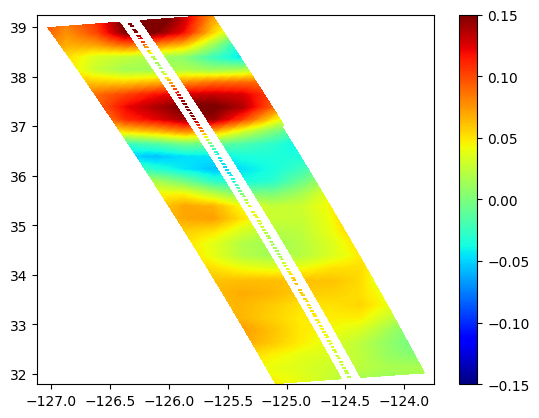

In [180]:
plt.pcolor(lon_026, lat_026,ssh_avi_026[81,:,:], vmin=-.15, vmax=.15,cmap='jet')
plt.colorbar()

/tmp/ipykernel_40491/3503341629.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


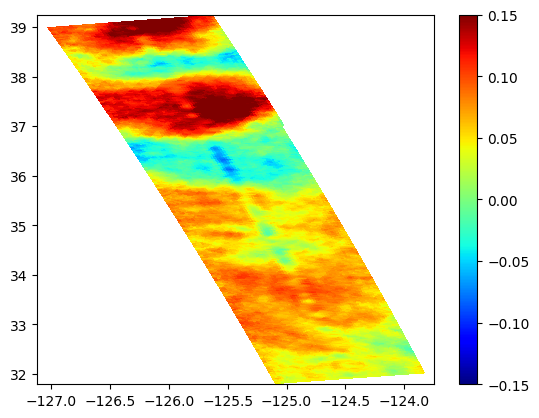

In [150]:
plt.pcolor(lon_026, lat_026,interpolated_data[81,:,:], vmin=-.15, vmax=.15,cmap='jet')
plt.colorbar()

In [151]:
# delta_lon, delta_lat = np.gradient(lon_026), np.gradient(lat_026)
# heading = np.arctan2(delta_lat, delta_lon)

/tmp/ipykernel_40491/4077937292.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


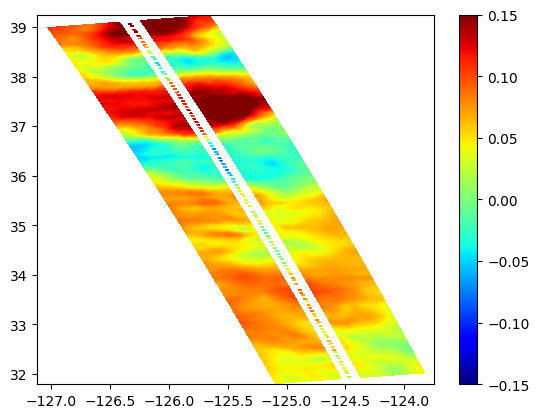

In [152]:
plt.pcolor(lon_026, lat_026,ssh_swot_026_nl[81,:,:], vmin=-.15, vmax=.15,cmap='jet')
plt.colorbar()

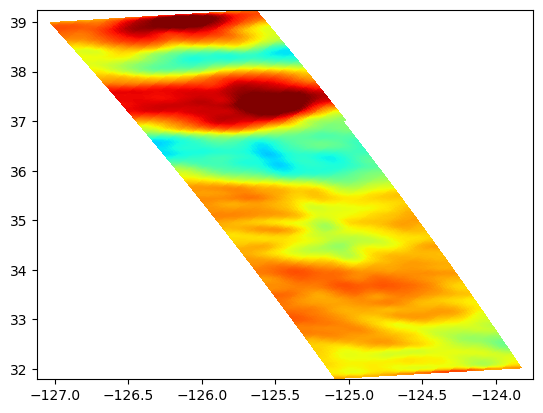

In [153]:
plt.pcolor(lon_026, lat_026,ssh_filt[81,:,:], vmin=-.15, vmax=.15,cmap='jet')


## compute the geostrophy velocity

In [85]:
# compute the geostrophy velocities though time
da_026 = compute_geostrophic_velocities_and_eke_through_time(time_026,lat_026, lon_026, ssh_swot_026,ssh_swot_026_nl,theta)#compute_geostrophic_velocities_and_eke_through_time(time_026,lat_026, lon_026, ssh_swot_026,ssh_swot_026_nl)

[[0.21736683 0.21758938 0.21781193 ... 0.23289079 0.233059   0.23334983]
 [0.2172917  0.21752022 0.21774276 ... 0.23279387 0.23302336 0.2332593 ]
 [0.21713831 0.21738789 0.21763149 ... 0.23264027 0.23286977 0.23309928]
 ...
 [0.17361355 0.17377212 0.17395198 ... 0.18477695 0.18495232 0.18511154]
 [0.17352362 0.17368699 0.17386686 ... 0.18468671 0.1848408  0.18502641]
 [0.17345498 0.17364443 0.17382429 ... 0.18463903 0.18477695 0.18496768]]


/tmp/ipykernel_40491/1803201720.py:134: RuntimeWarning: Mean of empty slice
  u_g_mean = np.nanmean(u_g, axis=0)
/tmp/ipykernel_40491/1803201720.py:135: RuntimeWarning: Mean of empty slice
  v_g_mean = np.nanmean(v_g, axis=0)
/tmp/ipykernel_40491/1803201720.py:136: RuntimeWarning: Mean of empty slice
  u_g_noiseless_mean = np.nanmean(u_g_noiseless, axis=0)
/tmp/ipykernel_40491/1803201720.py:137: RuntimeWarning: Mean of empty slice
  v_g_noiseless_mean = np.nanmean(v_g_noiseless, axis=0)


In [137]:
da_026_filt = compute_geostrophic_velocities_and_eke_through_time(time_026,lat_026, lon_026, ssh_swot_026,remove_adjacent_nans_3d(ssh_filt.data),theta)#compute_geostrophic_velocities_and_eke_through_time(time_026,lat_026, lon_026, ssh_swot_026,ssh_swot_026_nl)

[[0.21736683 0.21758938 0.21781193 ... 0.23289079 0.233059   0.23334983]
 [0.2172917  0.21752022 0.21774276 ... 0.23279387 0.23302336 0.2332593 ]
 [0.21713831 0.21738789 0.21763149 ... 0.23264027 0.23286977 0.23309928]
 ...
 [0.17361355 0.17377212 0.17395198 ... 0.18477695 0.18495232 0.18511154]
 [0.17352362 0.17368699 0.17386686 ... 0.18468671 0.1848408  0.18502641]
 [0.17345498 0.17364443 0.17382429 ... 0.18463903 0.18477695 0.18496768]]


/tmp/ipykernel_40491/1803201720.py:134: RuntimeWarning: Mean of empty slice
  u_g_mean = np.nanmean(u_g, axis=0)
/tmp/ipykernel_40491/1803201720.py:135: RuntimeWarning: Mean of empty slice
  v_g_mean = np.nanmean(v_g, axis=0)
/tmp/ipykernel_40491/1803201720.py:136: RuntimeWarning: Mean of empty slice
  u_g_noiseless_mean = np.nanmean(u_g_noiseless, axis=0)
/tmp/ipykernel_40491/1803201720.py:137: RuntimeWarning: Mean of empty slice
  v_g_noiseless_mean = np.nanmean(v_g_noiseless, axis=0)


In [138]:
# Calculate total velocity
da_026_filt["ut_g"] = np.sqrt(da_026_filt["u_g"] ** 2 + da_026_filt["v_g"] ** 2)
da_026_filt["ut_g_noiseless"] = np.sqrt(da_026_filt["u_east_noiseless"] ** 2 + da_026_filt["v_north_noiseless"] ** 2)

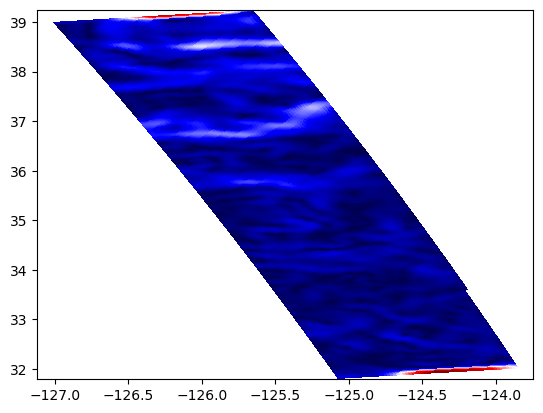

In [135]:
plt.pcolor(lon_026, lat_026,da_026_filt["ut_g_noiseless"].values[80,:,:], cmap='seismic')
# plt.pcolor(lon_026[:,35:], lat_026[:,35:],da_026_filt["u_g_noiseless"].values[80,:,35:], cmap='seismic')


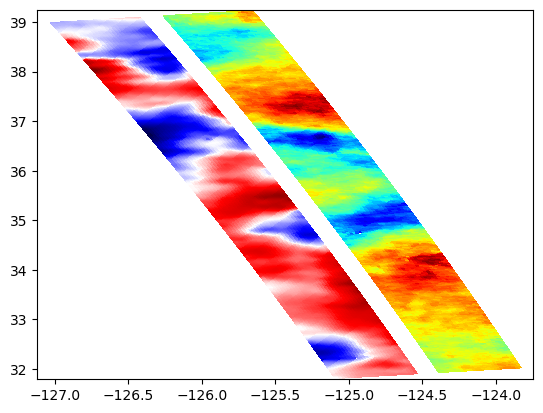

In [89]:
plt.pcolor(lon_026[:,0:34], lat_026[:,0:34],da_026["SSHA"].values[40,:,0:34], cmap='jet')
plt.pcolor(lon_026[:,35:], lat_026[:,35:],da_026["SSHA_noiseless"].values[40,:,35:], cmap='seismic')


In [30]:
# Create a mask where ssh_swot is NaN
nan_mask = np.isnan(da_026.u_east_noiseless.values)

# Calculate total velocity
# nc_avi_026["utgosa"] = np.sqrt(nc_avi_026["ugosa"] ** 2 + nc_avi_026["vgosa"] ** 2)

# Apply this mask to the entire dataset of aviso
da_026 = da_026.where(~nan_mask, other=np.nan)

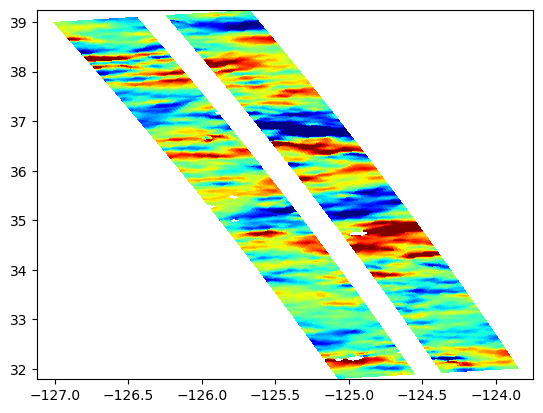

In [31]:
plt.pcolor(lon_026, lat_026,da_026["u_g_noiseless"].values[40,:,:],vmin=-.35, vmax=.35, cmap='jet')

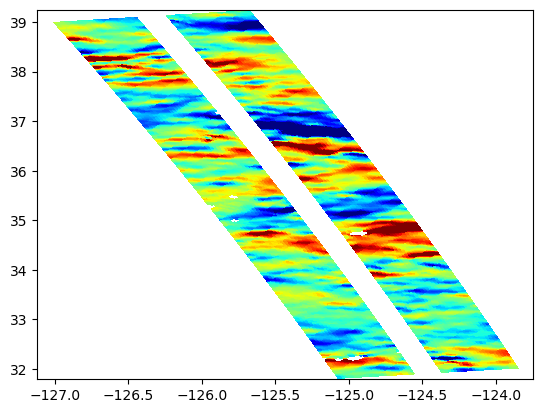

In [32]:
plt.pcolor(lon_026, lat_026,da_026["u_east_noiseless"].values[40,:,:],vmin=-.35, vmax=.35, cmap='jet')

In [31]:
# # Example: Original 2D array with NaN values
# original_array_u = da_026["u_g_noiseless"][60,:,0:34].values
# original_array_v = da_026["v_g_noiseless"][60,:,0:34].values
# original_array_ssh = da_026["SSHA_noiseless"][60,:,0:34].values
# original_array_lon = da_026["longitude"][:,0:34].values
# original_array_lat = da_026["latitude"][:,0:34].values

# # Create a mask of the NaN parts in the original array
# nan_mask = np.isnan(original_array_v)


# # Identify columns and rows where all values are NaN
# nan_columns = np.isnan(original_array_v).all(axis=0)
# nan_rows = np.isnan(original_array_v).all(axis=1)

# # take off the whole nan colum and row 
# data_cleaned_u = original_array_u[~nan_rows, :][:, ~nan_columns]
# data_cleaned_v = original_array_v[~nan_rows, :][:, ~nan_columns]
# data_cleaned_ssh = original_array_ssh[~nan_rows, :][:, ~nan_columns]
# data_cleaned_lon = original_array_lon[~nan_rows, :][:, ~nan_columns]
# data_cleaned_lat = original_array_lat[~nan_rows, :][:, ~nan_columns]


# # Step 1: Interpolate the valid part (2D array)
# if data_cleaned_u.shape[0] > 3 and data_cleaned_u.shape[1] > 3:
#     interp_u = pd.DataFrame(data_cleaned_u).interpolate(method='linear', axis=0).interpolate(method='linear', axis=1).to_numpy()#interpolate_nan_values(data_cleaned_u)
#     interp_v = pd.DataFrame(data_cleaned_v).interpolate(method='linear', axis=0).interpolate(method='linear', axis=1).to_numpy()#interpolate_nan_values(data_cleaned_v)
#     interp_ssh = pd.DataFrame(data_cleaned_ssh).interpolate(method='linear', axis=0).interpolate(method='linear', axis=1).to_numpy()#interpolate_nan_values(data_cleaned_ssh)

#     # Step 5: Compute cyclogeostrophic balance on the valid part (you'll need u_g, v_g, lon, lat)
#     u_g_valid, v_g_valid = iterative_cyclogeostrophic_balance(
#         u_g=interp_u, 
#         v_g=interp_v,  # You should replace with actual valid `v_g` 
#         lon=data_cleaned_lon,  # You should replace with actual longitude array
#         lat=data_cleaned_lat,  # You should replace with actual latitude array
#         max_iterations=1000, 
#         tol=0.01
#     )

#     # Step 6: Combine the computed results back into the original array
#     original_shape = original_array_u.shape
#     combined_u_g = np.full(original_shape, np.nan)
#     combined_v_g = np.full(original_shape, np.nan)
#     # Save the positions of NaN rows and columns
#     nan_columns_indices = np.where(~nan_columns)[0]
#     nan_rows_indices = np.where(~nan_rows)[0]

#     # Reinsert the cleaned data into the correct positions (non-NaN rows and columns)
#     combined_u_g[np.ix_(~nan_rows, ~nan_columns)] = u_g_valid
#     combined_v_g[np.ix_(~nan_rows, ~nan_columns)] = v_g_valid
    
#     # combined_u_g = combine_with_nan(original_array_u, u_g_valid, nan_mask, nan_rows, nan_columns)
#     # combined_v_g = combine_with_nan(original_array_v, v_g_valid, nan_mask, nan_rows, nan_columns)

#     # Now combined_u_g and combined_v_g have the computed cyclogeostrophic velocities
#     # with NaN values in the correct positions.
# # else:
# #     # If there are no valid parts, return the original array (with NaNs)
# #     combined_u_g = original_array_u
# #     combined_v_g = original_array_v

# print(combined_u_g)
# print(combined_v_g)

## loop through the loop

In [32]:
# Example usage
results_u_g, results_v_g,results_vort_g, results_vort_cg = process_time_series(da_026,  pixel_start=0, pixel_end=34)


/tmp/ipykernel_28883/1391350416.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


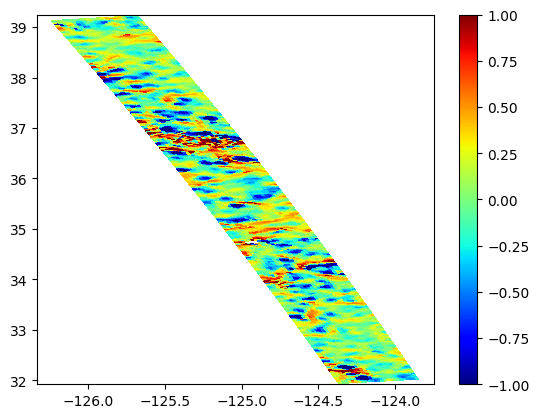

In [33]:
plt.pcolor(da_026.longitude[:,0:34],da_026.latitude[:,0:34],1E4*results_vort_cg[40], vmin=-1, vmax=1, cmap='jet')
plt.colorbar()

In [ ]:
plt.pcolor(da_026.longitude[:,0:34],da_026.latitude[:,0:34],1E4*results_vort_g[40], vmin=-1, vmax=1, cmap='jet')
plt.colorbar()

In [ ]:
pixel_start=0; pixel_end=34    
time_dim = da_026["u_g_noiseless"][:,:,pixel_start:pixel_end].shape[0]

for t in range(time_dim):
    plot_ssh_ug_ucg(da_026.SSHA_noiseless[t,:,pixel_start:pixel_end],da_026.u_g_noiseless[t,:,pixel_start:pixel_end], results_u_g[t],da_026.longitude[:,0:34],da_026.latitude[:,0:34])

In [ ]:
# # Apply the iterative scheme
# u_cyclo, v_cyclo = iterative_cyclogeostrophic_balance(interpolate_nan_values(da_026["u_g_noiseless"][40,:,5:29].values), 
#                                                       interpolate_nan_values(da_026["v_g_noiseless"][40,:,5:29].values),  lon_026[:,5:29], lat_026[:,5:29])

# compute the total velocity for AVISO --> -->

In [ ]:
# Create a mask where ssh_swot is NaN
nan_mask = np.isnan(da_026.ut_g.values)

# Calculate total velocity
nc_avi_026["utgosa"] = np.sqrt(nc_avi_026["ugosa"] ** 2 + nc_avi_026["vgosa"] ** 2)

# Apply this mask to the entire dataset of aviso
nc_avi_026 = nc_avi_026.where(~nan_mask, other=np.nan)

In [ ]:
nc_avi_026

In [ ]:
plt.pcolor(lon_026, lat_026,da_026["v_g_noiseless"][81,:,:], vmin=-.35, vmax=.35,cmap='seismic_r')

## compute and plot the sepctral analysis along the whole SWOT SWATH 

In [ ]:
plt.pcolor(lon_026, lat_026,da_026["v_north_noiseless"][81,:,:], vmin=-.35, vmax=.35,cmap='seismic_r')

In [ ]:
plt.pcolor(lon_026, lat_026,da_026["u_g_noiseless"][81,:,:], vmin=-.35, vmax=.35,cmap='seismic_r')

In [ ]:
plt.pcolor(lon_026, lat_026,da_026["u_east_noiseless"][81,:,:], vmin=-.35, vmax=.35,cmap='seismic_r')

In [ ]:
plt.pcolor(lon_026, lat_026,da_026["ut_g_noiseless"][81,:,:], vmin=0, vmax=.35,cmap='seismic')

In [ ]:
plt.pcolor(lon_026, lat_026,da_026["u_east_noiseless"][81,:,:], vmin=-.35, vmax=.35,cmap='seismic_r')

In [ ]:
plt.pcolor(lon_026, lat_026,(da_026["u_east_noiseless"][81,:,:] -da_026["u_g_noiseless"][81,:,:]) , vmin=-.1, vmax=.1,cmap='seismic_r')

In [ ]:
plt.pcolor(lon_026, lat_026,(da_026["v_north_noiseless"][81,:,:] -da_026["v_g_noiseless"][81,:,:]) , vmin=-.35, vmax=.35,cmap='seismic_r')

In [ ]:
lat_026,da_026["u_g_noiseless"][0,:,:].shape

In [ ]:
lat_026,da_026["u_east_noiseless"][0,:,:]-lat_026,da_026["u_g_noiseless"][0,:,:]

In [163]:
def apply_hanning(data, lat, lon, desired_resolution_km):
    dy, dx = determine_window_sizes(lat, lon, desired_resolution_km)
    
    window_alongtrack = np.hanning(dy)
    window_crosstrack = np.hanning(dx)
    window = window_alongtrack[:, None] * window_crosstrack[None, :]  # Create a 2D window
    window /= window.sum()  # Normalize the window to preserve data amplitude

    # Pad data to minimize edge effects
    pad_width_alongtrack = dy // 2
    pad_width_crosstrack = dx // 2
    data_padded = np.pad(data, ((pad_width_alongtrack, pad_width_alongtrack),
                                (pad_width_crosstrack, pad_width_crosstrack)), mode='reflect')

    # Handle NaNs by treating them as zero (influence can be limited by normalizing the window)
    nan_mask = np.isnan(data_padded)
    data_padded[nan_mask] = 0
    filtered_data = convolve2d(data_padded, window, mode='valid', boundary='fill', fillvalue=0)

    # Correct the NaN influence by reapplying the nan_mask
    nan_mask = nan_mask.astype(float)
    normalization = convolve2d(1 - nan_mask, window, mode='valid', boundary='fill', fillvalue=0)
    filtered_data /= normalization
    nan_result_mask = normalization == 0
    filtered_data[nan_result_mask] = np.nan

    return filtered_data


In [167]:
apply_hanning(ssh_swot_026_nl[it], lat_026, lon_026, desired_resolution_km)

/tmp/ipykernel_40491/570743511.py:23: RuntimeWarning: invalid value encountered in divide
  filtered_data /= normalization


array([[-0.02333934, -0.02333934, -0.02459471, ..., -0.0549344 ,
                nan,         nan],
       [-0.0238953 , -0.0238953 , -0.02509076, ..., -0.05402002,
                nan,         nan],
       [-0.02542788, -0.02542788, -0.02646741, ..., -0.05128529,
                nan,         nan],
       ...,
       [ 0.00492955,  0.00492955,  0.00631304, ..., -0.10178243,
                nan,         nan],
       [ 0.0050524 ,  0.0050524 ,  0.00654009, ..., -0.09870775,
                nan,         nan],
       [ 0.00508964,  0.00508964,  0.00661547, ..., -0.09749939,
                nan,         nan]])

## apply the filter 

In [170]:
# Apply Hanning filter with calculated sizes for 100 km
desired_resolution_km =79 ## for 110 km
filtered_026 = np.full_like(np.zeros((da_026.SSHA.shape[0],da_026.SSHA.shape[1],da_026.SSHA.shape[2])), np.nan) #np.(da_026.SSH)
for it, t in enumerate(da_026.time):
    filt_ssh = apply_hanning(ssh_swot_026_nl[it], lat_026, lon_026, desired_resolution_km) #apply_hanning(da_026.SSH[it,:,:], filt_y, filt_x)
    filtered_026[it] = np.where(np.isnan(ssh_swot_026[it,:,:]),np.nan,filt_ssh)

da_026_filt = compute_geostrophic_velocities_and_eke_through_time(time_026,lat_026, lon_026, ssh_swot_026,filtered_026,theta)#compute_geostrophic_velocities_through_time(time_026,lat_026, lon_026, filtered_026)
da_026_filt["ut_g"] = np.sqrt(da_026_filt["u_g"] ** 2 + da_026_filt["v_g"] ** 2)
da_026_filt["ut_g_noiseless"] = np.sqrt(da_026_filt["u_g_noiseless"] ** 2 + da_026_filt["v_g_noiseless"] ** 2)

/tmp/ipykernel_40491/570743511.py:23: RuntimeWarning: invalid value encountered in divide
  filtered_data /= normalization


[[0.21736683 0.21758938 0.21781193 ... 0.23289079 0.233059   0.23334983]
 [0.2172917  0.21752022 0.21774276 ... 0.23279387 0.23302336 0.2332593 ]
 [0.21713831 0.21738789 0.21763149 ... 0.23264027 0.23286977 0.23309928]
 ...
 [0.17361355 0.17377212 0.17395198 ... 0.18477695 0.18495232 0.18511154]
 [0.17352362 0.17368699 0.17386686 ... 0.18468671 0.1848408  0.18502641]
 [0.17345498 0.17364443 0.17382429 ... 0.18463903 0.18477695 0.18496768]]


/tmp/ipykernel_40491/1803201720.py:134: RuntimeWarning: Mean of empty slice
  u_g_mean = np.nanmean(u_g, axis=0)
/tmp/ipykernel_40491/1803201720.py:135: RuntimeWarning: Mean of empty slice
  v_g_mean = np.nanmean(v_g, axis=0)
/tmp/ipykernel_40491/1803201720.py:136: RuntimeWarning: Mean of empty slice
  u_g_noiseless_mean = np.nanmean(u_g_noiseless, axis=0)
/tmp/ipykernel_40491/1803201720.py:137: RuntimeWarning: Mean of empty slice
  v_g_noiseless_mean = np.nanmean(v_g_noiseless, axis=0)


/tmp/ipykernel_40491/2180928931.py:3: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


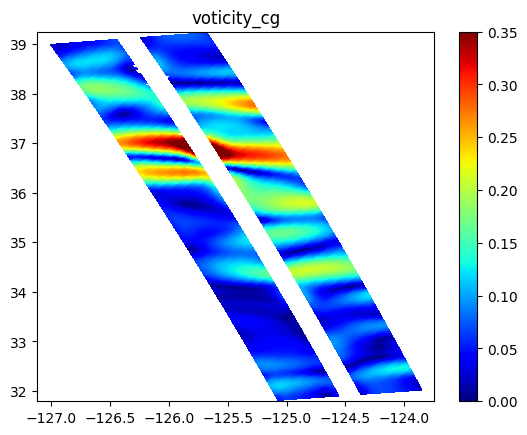

In [174]:
plt.pcolor(da_026.longitude,da_026.latitude,da_026_filt.ut_g_noiseless[51], vmin=0, vmax=.35, cmap='jet')
plt.title('voticity_cg')
plt.colorbar()

In [84]:
da_026.longitude.shape

(408, 69)

In [85]:
results_u_g_filt_part1, results_v_g_filt_part1, results_vort_g_filt_part1, results_vort_cg_filt_part1 = process_time_series(da_026_filt,  pixel_start=0, pixel_end=34)

results_u_g_filt_part2, results_v_g_filt_part2, results_vort_g_filt_part2, results_vort_cg_filt_part2 = process_time_series(da_026_filt,  pixel_start=34, pixel_end=69)

results_u_g_filt_combined = np.concatenate((results_u_g_filt_part1, results_u_g_filt_part2), axis=2)
results_v_g_filt_combined = np.concatenate((results_v_g_filt_part1, results_v_g_filt_part2), axis=2)
results_vort_g_filt_combined = np.concatenate((results_vort_g_filt_part1, results_vort_g_filt_part2), axis=2)
results_vort_cg_filt_combined = np.concatenate((results_vort_cg_filt_part1, results_vort_cg_filt_part2), axis=2)

/tmp/ipykernel_23185/883452919.py:3: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


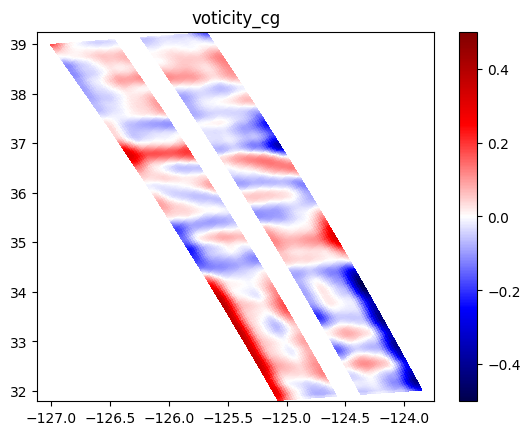

In [86]:
plt.pcolor(da_026.longitude,da_026.latitude,1E4*results_vort_cg_filt_combined[30], vmin=-.5, vmax=.5, cmap='seismic')
plt.title('voticity_cg')
plt.colorbar()

/tmp/ipykernel_23185/3710778110.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


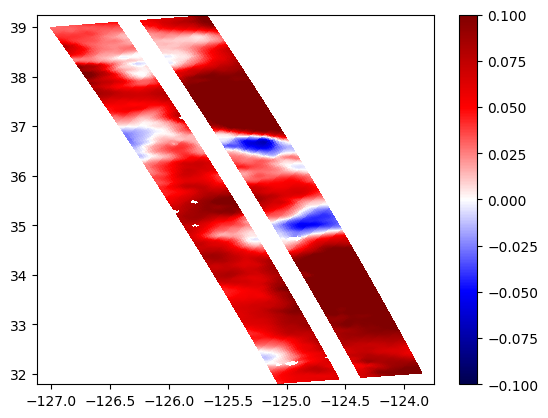

In [49]:
plt.pcolor(da_026.longitude,da_026.latitude,da_026.SSHA_noiseless[40], vmin=-.1, vmax=.1, cmap='seismic')
plt.colorbar()

/tmp/ipykernel_23185/2301390199.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


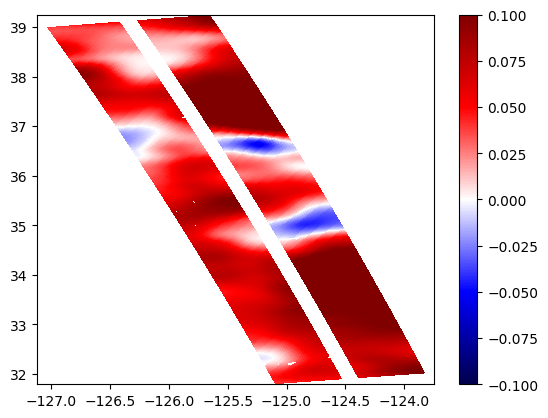

In [62]:
plt.pcolor(da_026.longitude,da_026.latitude,filtered_026[40], vmin=-.1, vmax=.1, cmap='seismic')
plt.colorbar()

/tmp/ipykernel_23185/3978912539.py:3: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


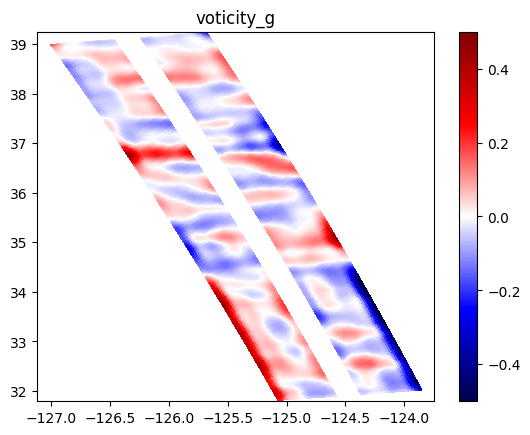

In [81]:
plt.pcolor(da_026.longitude,da_026.latitude,1E4*results_vort_g_filt_combined[30], vmin=-.5, vmax=.5, cmap='seismic')
plt.title('voticity_g')
plt.colorbar()

In [ ]:
pixel_start=0; pixel_end=34    
time_dim = da_026["u_g_noiseless"][:,:,pixel_start:pixel_end].shape[0]

for t in range(time_dim):
    plot_ssh_ug_ucg(da_026_filt.SSHA_noiseless[t,:,pixel_start:pixel_end],da_026_filt.u_g_noiseless[t,:,pixel_start:pixel_end], 
                    results_u_g_filt_part1[t],da_026.longitude[:,pixel_start:pixel_end],da_026.latitude[:,pixel_start:pixel_end])

In [ ]:
pixel_start=34; pixel_end=69    
time_dim = da_026["u_g_noiseless"][:,:,pixel_start:pixel_end].shape[0]

for t in range(time_dim):
    plot_ssh_ug_ucg(da_026_filt.SSHA_noiseless[t,:,pixel_start:pixel_end],da_026_filt.u_g_noiseless[t,:,pixel_start:pixel_end], results_u_g_filt_part2[t],
                    da_026.longitude[:,pixel_start:pixel_end],da_026.latitude[:,pixel_start:pixel_end])

In [ ]:
pixel_start=0; pixel_end=69   
time_dim = da_026["u_g_noiseless"][:,:,pixel_start:pixel_end].shape[0]
images_directory = '/home/tchonang/calval/figure/images/pass_026/swot/ssh_ug_ucg/'
for t in range(time_dim):
    subtitle=f"Time = {time_026[t]}"
    name_tosave="ssha_ug_ucg_swot_20km_filter_%02d.png" % t
    # plot_ssh_ug_ucg(ssh, u_g, u_cg, lon, lat, title1='SSH', title2='u_g', title3='u_cg', subtitle=subtitle, name_tosave, images_directory)
    plot_ssh_ug_ucg(da_026_filt.SSHA_noiseless[t,:,pixel_start:pixel_end],da_026_filt.u_g_noiseless[t,:,pixel_start:pixel_end], results_u_g_filt_combined[t],
                    da_026.longitude[:,pixel_start:pixel_end],da_026.latitude[:,pixel_start:pixel_end], title1='SSHA 20-km LPF', title2='u_g', title3='u_cg',
                    subtitle=subtitle, name_tosave=name_tosave, images_directory=images_directory)

In [ ]:
# Output video file path
output_video_path = images_directory + "ssh_ug_ucg_20km_filter_20230329_20230707_pass_026.mp4"

# Get a list of image files in the directory
image_files = sorted([file for file in os.listdir(images_directory) if file.endswith(".png")])

# Create a writer object to save the video
writer = imageio.get_writer(output_video_path, fps=2)  # Set the desired frames per second (fps)

# Iterate through the image files and add them to the video
for image_file in image_files:
    image_path = os.path.join(images_directory, image_file)
    image = imageio.imread(image_path)
    writer.append_data(image)

# Close the writer to finalize the video
writer.close()
#### Display the video using Video
# Video(output_video_path, embed=True, mimetype='video/mp4')


## apply filter on aviso

In [ ]:
# # Apply Hanning filter with calculated sizes for 100 km
# desired_resolution_km = 91 ## for 110 km
# filtered_avi_ssh = np.full_like(np.zeros((nc_avi_026.sla.shape[0],nc_avi_026.sla.shape[1],nc_avi_026.sla.shape[2])), np.nan) #np.(da_026.SSH)
# filtered_avi_ug = np.full_like(np.zeros((nc_avi_026.sla.shape[0],nc_avi_026.sla.shape[1],nc_avi_026.sla.shape[2])), np.nan) #np.(da_026.SSH)
# filtered_avi_vg = np.full_like(np.zeros((nc_avi_026.sla.shape[0],nc_avi_026.sla.shape[1],nc_avi_026.sla.shape[2])), np.nan) #np.(da_026.SSH)
# filtered_avi_utg = np.full_like(np.zeros((nc_avi_026.sla.shape[0],nc_avi_026.sla.shape[1],nc_avi_026.sla.shape[2])), np.nan) #np.(da_026.SSH)

# for it, t in enumerate(da_026.time):
#     filtered_avi_ssh[it] = apply_hanning(nc_avi_026.sla[it,:,:], lat_026, lon_026, desired_resolution_km) #apply_hanning(da_026.SSH[it,:,:], filt_y, filt_x)
#     filtered_avi_ug[it] = apply_hanning(nc_avi_026.ugosa[it,:,:], lat_026, lon_026, desired_resolution_km)
#     filtered_avi_vg[it] = apply_hanning(nc_avi_026.vgosa[it,:,:], lat_026, lon_026, desired_resolution_km)
#     filtered_avi_utg[it] = apply_hanning(nc_avi_026.utgosa[it,:,:], lat_026, lon_026, desired_resolution_km)
#     # filtered_avi_ssh[it] = apply_hanning(nc_avi_026.sla[it,:,:], lat_026, lon_026, desired_resolution_km)
#     # filtered_026[it] = np.where(np.isnan(ssh_swot_026[it,:,:]),np.nan,filt_ssh_avi)


In [ ]:
desired_resolution_km

In [ ]:
# nc_avi_026["ugosa_filt"] = (('time', 'num_lines', 'num_pixels'), filtered_avi_ug)
# nc_avi_026["vgosa_filt"] = (('time', 'num_lines', 'num_pixels'), filtered_avi_vg)
# nc_avi_026["sla_filt"] = (('time', 'num_lines', 'num_pixels'), filtered_avi_ssh)
# nc_avi_026["utgosa_filt"] = (('time', 'num_lines', 'num_pixels'), filtered_avi_utg)

## save my data

In [41]:
directory = '/mnt/flow/swot/Matt_Analysis/CNES_L3_CalVal/version_V1_0/swot_aviso/'

In [87]:
# da_026.to_netcdf(directory+'SUBSET_SWOT_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')
# nc_avi_026.to_netcdf(directory+'SUBSET_AVISO_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')
da_026_filt.to_netcdf(directory+'NEW_FILT70KM_test_SUBSET_SWOT_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')

## save the cyclogeostrophy data 

In [88]:
ds_tosave = xr.Dataset(
    {
        'ucg_east_noiseless': (['time', 'num_lines', 'num_pixels'], results_u_g_filt_combined),
        'vcg_north_noiseless': (['time', 'num_lines', 'num_pixels'], results_v_g_filt_combined),
        'vorticity_g_noiseless': (['time', 'num_lines', 'num_pixels'], results_vort_g_filt_combined),
        'vorticity_cg_noiseless': (['time', 'num_lines', 'num_pixels'], results_vort_cg_filt_combined),
        'SSHA_noiseless': (['time', 'num_lines', 'num_pixels'], da_026_filt.SSHA_noiseless.values),
        'SSHA': (['time', 'num_lines', 'num_pixels'], da_026_filt.SSHA.values),
        'ug_east_noiseless': (['time', 'num_lines', 'num_pixels'], da_026_filt.u_east_noiseless.values),
        'vg_north_noiseless': (['time', 'num_lines', 'num_pixels'], da_026_filt.v_north_noiseless.values)
        
    },
    coords={
        'time': da_026.time.values,  # 1D time coordinate
        'longitude': (['num_lines', 'num_pixels'], da_026.longitude.values),  # 2D longitude coordinate
        'latitude': (['num_lines', 'num_pixels'], da_026.latitude.values)    # 2D latitude coordinate
    }
)

# Optionally save the dataset to a NetCDF file
ds_tosave.to_netcdf(directory+'NEW_CG_FILT70KM_test_SUBSET_SWOT_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')

In [ ]:
da_026_filt["EKE"] = 1/2*(da_026_filt["u_g_noiseless"]**2+da_026_filt["v_g_noiseless"]**2)

In [ ]:
da_026_filt["EKE_t"] = 1/2*(da_026_filt["u_g"]**2+da_026_filt["v_g"]**2)

In [ ]:
tracks = np.arange(0, da_026_filt["SSHA_noiseless"].values[1:,:,:].shape[2])
result_ssh = compute_spectrum(da_026_filt["SSHA_noiseless"].values[1:,:,:], da_026_filt["SSHA"].values[1:,:,:], da_026.longitude.values, da_026.latitude.values, tracks)
result_u = compute_spectrum(da_026_filt["u_g_noiseless"].values[1:,:,:], da_026_filt["u_g"].values[1:,:,:], da_026.longitude.values, da_026.latitude.values, tracks)
result_v = compute_spectrum(da_026_filt["v_g_noiseless"].values[1:,:,:], da_026_filt["v_g"].values[1:,:,:], da_026.longitude.values, da_026.latitude.values, tracks)
result_eke = compute_spectrum(da_026_filt["eke_noiseless"].values[1:,:,:], da_026_filt["eke"].values[1:,:,:], da_026.longitude.values, da_026.latitude.values, tracks)

In [ ]:
result_eke

In [ ]:
da_026_filt

In [ ]:
np.array(result_ssh['PI']).shape

In [ ]:
flattened_K = [item for sublist in result_ssh['K'] for item in sublist]
flattened_P = [item for sublist in result_ssh['P'] for item in sublist]
flattened_P_obs = [item for sublist in result_ssh['P_obs'] for item in sublist]

# Convert flattened lists to NumPy arrays (optional but may be useful for plotting)
flattened_K = np.array(flattened_K)
flattened_P = np.array(flattened_P)
flattened_P_obs = np.array(flattened_P_obs)
KI = np.tile(result_ssh['kspace'], (np.array(result_ssh['PI']).shape[0], np.array(result_ssh['PI']).shape[2], 1)).transpose(0, 2, 1)

km, psd_ssha_noiseless, psd_ssha, psd_ssha_diff = np.nanmean(KI, axis = (0,2)), np.nanmean(result_ssh['PI'], axis = (0,2)), np.nanmean(result_ssh['PI_obs'], axis = (0,2)), np.nanmean(result_ssh['PI_diff'], axis = (0,2))



In [ ]:
da_026_filt

In [ ]:
# Now you can use flattened_K and flattened_P for plotting
plt.figure(figsize=(8, 5))

plt.loglog(km, psd_ssha, '-k', label='SSHA')
plt.loglog(km, psd_ssha_noiseless, '-r', label='SSHA noiseless')
plt.loglog(km, psd_ssha_diff, '-b', label='(SSHA - SSHA_noiseless)')

plt.axvline(x=1/70, color='k', linestyle='--')
# Adding grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim([1E-16, 1E0])
plt.xlim([1E-3, 1/3])
plt.xlabel("Wavenumber (cpkm)")
plt.ylabel("Power Density")
# plt.title("Power Density vs. Wavenumber")
plt.legend()
plt.show()

In [ ]:
# Now you can use flattened_K and flattened_P for plotting
lw = 2
plt.figure(figsize=(8, 5))

plt.loglog(km, psd_ssha, '-k',lw =lw, label='SSHA unfiltered')
plt.loglog(km, psd_ssha_noiseless, '-r',lw =lw, label='SSHA 65-km filtered')
plt.loglog(km, psd_ssha_diff, '-b',lw =lw, label='(SSHA unfiltered - SSHA 65-km filtered)')

plt.axvline(x=1/15, color='k', linestyle='--')
# Adding grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim([1E-6, 1E0])
plt.xlim([1E-3, 1/3])
plt.xlabel("Wavenumber (cpkm)")
plt.ylabel("Power Density")
plt.ylabel(r'PSD [m$^2$/cpkm]')#('PSD (V^2/Hz)')
# plt.title("Power Density vs. Wavenumber")
plt.legend()
plt.show()

In [ ]:
psd_eke_noiseless1, psd_eke1, psd_eke_diff1 = np.nanmean(result_eke['PI'], axis = (0,2)), np.nanmean(result_eke['PI_obs'], axis = (0,2)), np.nanmean(result_eke['PI_diff'], axis = (0,2))


In [ ]:
psd_u_noiseless, psd_u, psd_u_diff = np.nanmean(result_u['PI'], axis = (0,2)), np.nanmean(result_u['PI_obs'], axis = (0,2)), np.nanmean(result_u['PI_diff'], axis = (0,2))
psd_v_noiseless, psd_v, psd_v_diff = np.nanmean(result_v['PI'], axis = (0,2)), np.nanmean(result_v['PI_obs'], axis = (0,2)), np.nanmean(result_v['PI_diff'], axis = (0,2))


In [ ]:
psd_eke = 0.5*(psd_u+psd_v)
psd_eke_noiseless= 0.5*(psd_u_noiseless+psd_v_noiseless)
psd_eke_diff = 0.5*(psd_u_diff+psd_v_diff)

In [ ]:
# Now you can use flattened_K and flattened_P for plotting
plt.figure(figsize=(8, 5))

plt.loglog(km, psd_eke, '-k',lw = lw, label='EKE')
plt.loglog(km, psd_eke_noiseless, '-r', lw=lw,label='EKE_noiseless')
plt.loglog(km, psd_eke_diff, '-b', lw=lw, label='(EKE - EKE_noiseless)')

# plt.axvline(x=1/15, color='k', linestyle='--')
# Adding grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim([1E-4, 1E1])
plt.xlim([1E-3, 1/3])
plt.xlabel("Wavenumber (cpkm)")
plt.ylabel(r'PSD [m$^2$.s$^{-2}$/cpkm]')#('PSD (V^2/Hz)')
# plt.title("Power Density vs. Wavenumber")
plt.legend()
plt.show()

In [ ]:
# Now you can use flattened_K and flattened_P for plotting
plt.figure(figsize=(8, 5))

plt.loglog(km, np.sqrt(psd_eke1), '-k',lw = lw, label='EKE')
plt.loglog(km, np.sqrt(psd_eke_noiseless1), '-r', lw=lw,label='EKE_noiseless')
plt.loglog(km, np.sqrt(psd_eke_diff1), '-b', lw=lw, label='(EKE - EKE_noiseless)')

# plt.axvline(x=1/15, color='k', linestyle='--')
# Adding grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim([1E-2, 5E0])
plt.xlim([1E-3, 1/3])
plt.xlabel("Wavenumber (cpkm)")
plt.ylabel(r'PSD [m$^2$.s$^{-2}$/cpkm]')#('PSD (V^2/Hz)')
# plt.title("Power Density vs. Wavenumber")
plt.legend()
plt.show()

In [ ]:
# Now you can use flattened_K and flattened_P for plotting
plt.figure(figsize=(8, 5))

plt.loglog(km, psd_eke, '-k',lw = lw, label='EKE')
plt.loglog(km, psd_eke_noiseless, '-r', lw=lw,label='EKE noiseless')
plt.loglog(km, psd_eke_diff, '-b', lw=lw, label='(EKE - EKE_noiseless)')

# plt.axvline(x=1/15, color='k', linestyle='--')
# Adding grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim([1E-12, 1E0])
plt.xlim([1E-3, 1/3])
plt.xlabel("Wavenumber (cpkm)")
plt.ylabel(r'PSD [m$^2$.s$^{-2}$/cpkm]')#('PSD (V^2/Hz)')
# plt.title("Power Density vs. Wavenumber")
plt.legend()
plt.show()

In [ ]:
# Now you can use flattened_K and flattened_P for plotting
plt.figure(figsize=(8, 5))

plt.loglog(km, psd_ssha, '-k', label='SSHA')
plt.loglog(km, psd_eke, '-r', label='EKE')
# plt.loglog(km, psd_eke_diff, '-b', label='(EKE - EKE_noiseless)')

plt.axvline(x=1/15, color='k', linestyle='--')
# Adding grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim([1E-5, 1E0])
plt.xlim([1E-3, 1/3])
plt.xlabel("Wavenumber (cpkm)")
plt.ylabel("Power Density")
# plt.title("Power Density vs. Wavenumber")
plt.legend()
plt.show()

### plot the toatal velocity

In [ ]:
# Loop through each time step and plot

# Common plot parameters
params_ut = {
    'vmin': 0,
    'vmax': 0.4,
    'x': 'longitude',
    'y': 'latitude',
    'xlim': (-127, -124),
    'ylim': (32, 39),
    'cmap': 'jet',
    'add_colorbar': False  # Disable individual colorbars
}

params_uv = {
    'vmin': -0.25,
    'vmax': 0.25,
    'x': 'longitude',
    'y': 'latitude',
    'xlim': (-127, -124),
    'ylim': (32, 39),
    'cmap': 'seismic_r',
    'add_colorbar': False  # Disable individual colorbars
}

# cmap = plt.cm.RdBu_r
xtick = ['-127','-126.5','-126', '-125.5','-125', '-124.5', '-124']
list1=[-127, -126.5, -126, -125.5,-125, -124.5, -124]
ytick = ['32','33','34','35','36','37','38','39']
list2=[32, 33, 34, 35, 36, 37,38, 39]
tick_uv = [-.25, -.2,-.15,-.1,-.05,0,.05,.1,.15, .2,.25]
tick_ut = [0,.05,.1,.15, .2,.25,.3,.35,.4]
cb = 'm.s$^{-1}$'
font = 25; n=8
images_directory = '/home/tchonang/calval/figure/images/pass_026/swot/'
# Set the figure resolution (optional)
dpi = 300  # Set the desired dots per inch (DPI)
label_fontsize = 14
tick_fontsize = 12
title_fontsize = 16

for it,t in enumerate(da_026.time):
    fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=True)
    
    # Zonal velocity
    u_plot = da_026.u_g.sel(time=t).plot(ax=axes[0], **params_uv)
    axes[0].set_title('Zonal Velocity')
    axes[0].set_xticks(list1, xtick)
    axes[0].set_yticks(list2)
    axes[0].set_xticklabels(xtick,fontsize=label_fontsize)
    axes[0].set_yticklabels(ytick,fontsize=label_fontsize)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    
    # Meridional velocity
    u_plot = da_026.v_g.sel(time=t).plot(ax=axes[1], **params_uv)
    axes[1].set_title('Meridional Velocity')
    axes[1].set_xticks(list1)
    axes[1].set_yticks(list2)
    axes[1].set_xticklabels(xtick,fontsize=label_fontsize)
    axes[1].set_yticklabels(ytick,fontsize=label_fontsize)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    
    # Total velocity
    total_plot = da_026.ut_g.sel(time=t).plot(ax=axes[2], **params_ut)
    axes[2].set_title('Total Velocity')
    axes[2].set_xticks(list1)
    axes[2].set_yticks(list2)
    axes[2].set_xticklabels(xtick,fontsize=label_fontsize)
    axes[2].set_yticklabels(ytick,fontsize=label_fontsize)
    axes[2].set_xlabel('')
    axes[2].set_ylabel('')
    
    # Create colorbar axes
    cbar_ax_u_v = fig.add_axes([0.05, 0.01, 0.6, 0.02])  # [left, bottom, width, height]
    cbar_ax_total = fig.add_axes([0.75, 0.01, 0.2, 0.02])  # [left, bottom, width, height]
    
    # Add colorbars
    cbar_u_v = ColorbarBase(cbar_ax_u_v, cmap='seismic', norm=u_plot.norm, orientation='horizontal',ticks=tick_uv, extend='both')
    cbar_u_v.set_label(cb, fontsize=label_fontsize)
    cbar_u_v.ax.tick_params(labelsize=tick_fontsize)
    
    cbar_total = ColorbarBase(cbar_ax_total, cmap='jet', norm=total_plot.norm, orientation='horizontal', extend='max')
    cbar_total.set_label(cb, fontsize=label_fontsize)
    cbar_total.ax.tick_params(labelsize=tick_fontsize)
    
    
    # Set the main title
    fig.suptitle(f"Velocity Components at Time = {t.values}", fontsize=title_fontsize, y=0.92, color='blue')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show the plot
    plt.savefig(images_directory+"velocity_components_swot_%02d.png" % it,
                 transparent = False, bbox_inches = 'tight', dpi = 300)
    plt.show()

## create a video of that total velocity

In [ ]:
# Output video file path
output_video_path = images_directory + "velocity_components_swot_video_20230329_20230707_pass_026.mp4"

# Get a list of image files in the directory
image_files = sorted([file for file in os.listdir(images_directory) if file.endswith(".png")])

# Create a writer object to save the video
writer = imageio.get_writer(output_video_path, fps=2)  # Set the desired frames per second (fps)

# Iterate through the image files and add them to the video
for image_file in image_files:
    image_path = os.path.join(images_directory, image_file)
    image = imageio.imread(image_path)
    writer.append_data(image)

# Close the writer to finalize the video
writer.close()
#### Display the video using Video
# Video(output_video_path, embed=True, mimetype='video/mp4')


In [ ]:
da_026

## apply the filter on 100 km 

In [ ]:
# Apply Hanning filter with calculated sizes for 100 km
desired_resolution_km = 67 ## for 110 km
filtered_026 = np.full_like(np.zeros((da_026.SSHA.shape[0],da_026.SSHA.shape[1],da_026.SSHA.shape[2])), np.nan) #np.(da_026.SSH)
for it, t in enumerate(da_026.time):
    filt_ssh = apply_hanning(da_026.SSHA[it,:,:], lat_026, lon_026, desired_resolution_km) #apply_hanning(da_026.SSH[it,:,:], filt_y, filt_x)
    filtered_026[it] = np.where(np.isnan(ssh_swot_026[it,:,:]),np.nan,filt_ssh)

da_026_filt = compute_geostrophic_velocities_and_eke_through_time(time_026,lat_026, lon_026, ssh_swot_026,filtered_026)#compute_geostrophic_velocities_through_time(time_026,lat_026, lon_026, filtered_026)
da_026_filt["ut_g"] = np.sqrt(da_026_filt["u_g"] ** 2 + da_026_filt["v_g"] ** 2)
da_026_filt["ut_g_noiseless"] = np.sqrt(da_026_filt["u_g_noiseless"] ** 2 + da_026_filt["v_g_noiseless"] ** 2)

In [ ]:
plt.pcolor(da_026.longitude,da_026.latitude,da_026_filt.ut_g[40],vmin = 0, vmax = .4, cmap ='jet')

In [ ]:
plt.pcolor(da_026.longitude,da_026.latitude,da_026_filt.ut_g_noiseless[40],vmin = 0, vmax = .4, cmap ='jet')

In [ ]:
plt.pcolor(da_026.longitude,da_026.latitude,da_026.ut_g_noiseless[40],vmin = 0, vmax = .4, cmap ='jet')

In [ ]:
plt.pcolor(da_026.longitude,da_026.latitude,filtered_026[80] ,vmin = -0.15, vmax = .15, cmap ='jet')

In [ ]:
plt.pcolor(da_026.longitude,da_026.latitude,nc_avi_026.sla[80] ,vmin = -0.15, vmax = .15, cmap ='jet')

In [ ]:
plt.pcolor(da_026.longitude,da_026.latitude,nc_avi_026.utgosa[40],vmin = 0, vmax = .4, cmap ='jet')

## plot aviso plus swot

In [ ]:
# Common plot parameters
params_ut = {
    'vmin': 0,
    'vmax': 0.25,
    'x': 'longitude',
    'y': 'latitude',
    'xlim': (-127, -124),
    'ylim': (32, 39),
    'cmap': 'jet',
    'add_colorbar': False  # Disable individual colorbars
}

params_uv = {
    'vmin': -0.25,
    'vmax': 0.25,
    'x': 'longitude',
    'y': 'latitude',
    'xlim': (-127, -124),
    'ylim': (32, 39),
    'cmap': 'seismic_r',
    'add_colorbar': False  # Disable individual colorbars
}

xtick = ['-127','-126.5','-126', '-125.5','-125', '-124.5', '-124']
list1=[-127, -126.5, -126, -125.5,-125, -124.5, -124]
ytick = ['32','33','34','35','36','37','38','39']
list2=[32, 33, 34, 35, 36, 37, 38, 39]
tick_uv = [-.25, -.2, -.15, -.1, -.05, 0, .05, .1, .15, .2, .25]
tick_ut = [0, .05, .1, .15, .2, .25]
cb = 'm.s$^{-1}$'
font = 25; n=8
images_directory = '/home/tchonang/calval/figure/images/pass_026/swot_aviso/'
# Set the figure resolution (optional)
dpi = 300  # Set the desired dots per inch (DPI)
label_fontsize = 14
tick_fontsize = 12
title_fontsize = 16

# Loop through each time step and plot for both datasets
for it, t in enumerate(da_026_filt.time):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
    
    # SWOT Data
    # Zonal velocity
    u_plot_swot = da_026_filt.u_g.sel(time=t).plot(ax=axes[0, 0], **params_uv)
    axes[0, 0].set_title('SWOT Zonal Velocity')
    axes[0, 0].set_xticks(list1)
    axes[0, 0].set_yticks(list2)
    axes[0, 0].set_xticklabels(xtick, fontsize=label_fontsize)
    axes[0, 0].set_yticklabels(ytick, fontsize=label_fontsize)
    axes[0, 0].set_xlabel('')
    axes[0, 0].set_ylabel('')
    
    # Meridional velocity
    v_plot_swot = da_026_filt.v_g.sel(time=t).plot(ax=axes[0, 1], **params_uv)
    axes[0, 1].set_title('SWOT Meridional Velocity')
    axes[0, 1].set_xticks(list1)
    axes[0, 1].set_yticks(list2)
    axes[0, 1].set_xticklabels(xtick, fontsize=label_fontsize)
    axes[0, 1].set_yticklabels(ytick, fontsize=label_fontsize)
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('')
    
    # Total velocity
    total_plot_swot = da_026_filt.ut_g.sel(time=t).plot(ax=axes[0, 2], **params_ut)
    axes[0, 2].set_title('SWOT Total Velocity')
    axes[0, 2].set_xticks(list1)
    axes[0, 2].set_yticks(list2)
    axes[0, 2].set_xticklabels(xtick, fontsize=label_fontsize)
    axes[0, 2].set_yticklabels(ytick, fontsize=label_fontsize)
    axes[0, 2].set_xlabel('')
    axes[0, 2].set_ylabel('')
    
    # AVISO Data
    # Zonal velocity
    u_plot_aviso = nc_avi_026.ugosa.sel(time=t).plot(ax=axes[1, 0], **params_uv)
    axes[1, 0].set_title('AVISO Zonal Velocity')
    axes[1, 0].set_xticks(list1)
    axes[1, 0].set_yticks(list2)
    axes[1, 0].set_xticklabels(xtick, fontsize=label_fontsize)
    axes[1, 0].set_yticklabels(ytick, fontsize=label_fontsize)
    axes[1, 0].set_xlabel('')
    axes[1, 0].set_ylabel('')
    
    # Meridional velocity
    v_plot_aviso = nc_avi_026.vgosa.sel(time=t).plot(ax=axes[1, 1], **params_uv)
    axes[1, 1].set_title('AVISO Meridional Velocity')
    axes[1, 1].set_xticks(list1)
    axes[1, 1].set_yticks(list2)
    axes[1, 1].set_xticklabels(xtick, fontsize=label_fontsize)
    axes[1, 1].set_yticklabels(ytick, fontsize=label_fontsize)
    axes[1, 1].set_xlabel('')
    axes[1, 1].set_ylabel('')
    
    # Total velocity
    total_plot_aviso = nc_avi_026.utgosa.sel(time=t).plot(ax=axes[1, 2], **params_ut)
    axes[1, 2].set_title('AVISO Total Velocity')
    axes[1, 2].set_xticks(list1)
    axes[1, 2].set_yticks(list2)
    axes[1, 2].set_xticklabels(xtick, fontsize=label_fontsize)
    axes[1, 2].set_yticklabels(ytick, fontsize=label_fontsize)
    axes[1, 2].set_xlabel('')
    axes[1, 2].set_ylabel('')
    
    # Create colorbar axes
    cbar_ax_u_v = fig.add_axes([0.05, 0.07, 0.6, 0.02])  # [left, bottom, width, height]
    cbar_ax_total = fig.add_axes([0.75, 0.07, 0.2, 0.02])  # [left, bottom, width, height]
    
    # Add colorbars
    cbar_u_v = ColorbarBase(cbar_ax_u_v, cmap='seismic', norm=u_plot_swot.norm, orientation='horizontal', ticks=tick_uv, extend='both')
    cbar_u_v.set_label(cb, fontsize=label_fontsize)
    cbar_u_v.ax.tick_params(labelsize=tick_fontsize)
    
    cbar_total = ColorbarBase(cbar_ax_total, cmap='jet', norm=total_plot_swot.norm, orientation='horizontal', ticks=tick_ut, extend='max')
    cbar_total.set_label(cb, fontsize=label_fontsize)
    cbar_total.ax.tick_params(labelsize=tick_fontsize)
    
    # Set the main title
    fig.suptitle(f"Velocity Components for SWOT and AVISO at Time = {t.values}", fontsize=title_fontsize, y=0.94)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    
    # Save and show the plot
    plt.savefig(images_directory + "velocity_components_swot_100km_filter_aviso_%02d.png" % it,
                transparent=False, bbox_inches='tight', dpi=dpi)
    plt.show()

In [ ]:
nc_avi_026

In [ ]:
images_directory

## create a video

In [ ]:
# Output video file path
output_video_path = images_directory + "velocity_components_swot_100km_filter_aviso_20230329_20230707_pass_026.mp4"

# Get a list of image files in the directory
image_files = sorted([file for file in os.listdir(images_directory) if file.endswith(".png")])

# Create a writer object to save the video
writer = imageio.get_writer(output_video_path, fps=2)  # Set the desired frames per second (fps)

# Iterate through the image files and add them to the video
for image_file in image_files:
    image_path = os.path.join(images_directory, image_file)
    image = imageio.imread(image_path)
    writer.append_data(image)

# Close the writer to finalize the video
writer.close()
#### Display the video using Video
# Video(output_video_path, embed=True, mimetype='video/mp4')


## plot of SSH

In [ ]:
# Loop through each time step and plot

# Common plot parameters
params = {
    'vmin': -0.15,
    'vmax': 0.15,
    'x': 'longitude',
    'y': 'latitude',
    'xlim': (-127, -124),
    'ylim': (32, 39),
    'cmap': plt.cm.RdBu_r,
    'add_colorbar': False  # Disable individual colorbars
}

# cmap = plt.cm.RdBu_r
xtick = ['-127','-126.5','-126', '-125.5','-125', '-124.5', '-124']
list1=[-127, -126.5, -126, -125.5,-125, -124.5, -124]
ytick = ['32','33','34','35','36','37','38','39']
list2=[32, 33, 34, 35, 36, 37,38, 39]
tick = [-.15,-.1,-.05,0,.05,.1,.15]
cb = 'm'
font = 25; n=8
images_directory = '/home/tchonang/calval/figure/images/pass_026/SSH/'
# Set the figure resolution (optional)
dpi = 300  # Set the desired dots per inch (DPI)
label_fontsize = 14
tick_fontsize = 12
title_fontsize = 16

for it,t in enumerate(da_026.time):
    fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=True)
    
    # Zonal velocity
    u_plot = da_026.SSH.sel(time=t).plot(ax=axes[0], **params)
    axes[0].set_title('SLA: SWOT',fontsize=label_fontsize)
    axes[0].set_xticks(list1, xtick)
    axes[0].set_yticks(list2)
    axes[0].set_xticklabels(xtick,fontsize=label_fontsize)
    axes[0].set_yticklabels(ytick,fontsize=label_fontsize)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    
    # Meridional velocity
    u_plot = da_026_filt.SSH.sel(time=t).plot(ax=axes[1], **params)
    axes[1].set_title('SLA 100km filtered: SWOT',fontsize=label_fontsize)
    axes[1].set_xticks(list1)
    axes[1].set_yticks(list2)
    axes[1].set_xticklabels(xtick,fontsize=label_fontsize)
    axes[1].set_yticklabels(ytick,fontsize=label_fontsize)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    
    # Total velocity
    total_plot = nc_avi_026.sla.sel(time=t).plot(ax=axes[2], **params)
    axes[2].set_title('SLA: AVISO',fontsize=label_fontsize)
    axes[2].set_xticks(list1)
    axes[2].set_yticks(list2)
    axes[2].set_xticklabels(xtick,fontsize=label_fontsize)
    axes[2].set_yticklabels(ytick,fontsize=label_fontsize)
    axes[2].set_xlabel('')
    axes[2].set_ylabel('')
    
    # Add colorbars
    cbar_ax = fig.add_axes([1, 0.13, 0.015, 0.75])
    cbar = fig.colorbar(u_plot, cax=cbar_ax, cmap=plt.cm.RdBu_r, ticks = tick,
                        extend = 'both')
    cbar.ax.tick_params(labelsize=font)
    cbar.ax.set_title(cb,fontsize=font)
    
    
    # Set the main title
    fig.suptitle(f"Time = {t.values}", fontsize=title_fontsize, y=0.92, color='blue')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show the plot
    plt.savefig(images_directory+"SSH_SWOT_AVISO_%02d.png" % it,
                 transparent = False, bbox_inches = 'tight', dpi = 300)
    plt.show()

In [ ]:
# Output video file path
output_video_path = images_directory + "ssh_swot_100km_filter_aviso_20230329_20230707_pass_026.mp4"

# Get a list of image files in the directory
image_files = sorted([file for file in os.listdir(images_directory) if file.endswith(".png")])

# Create a writer object to save the video
writer = imageio.get_writer(output_video_path, fps=2)  # Set the desired frames per second (fps)

# Iterate through the image files and add them to the video
for image_file in image_files:
    image_path = os.path.join(images_directory, image_file)
    image = imageio.imread(image_path)
    writer.append_data(image)

# Close the writer to finalize the video
writer.close()
#### Display the video using Video
# Video(output_video_path, embed=True, mimetype='video/mp4')

## save my data 

In [ ]:
directory = '/mnt/flow/swot/Matt_Analysis/CNES_L3_CalVal/version_V1_0/swot_aviso/'
da_026.to_netcdf(directory+'SUBSET_SWOT_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')
nc_avi_026.to_netcdf(directory+'SUBSET_AVISO_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')

In [ ]:
da_026_filt.to_netcdf(directory+'FILT65KM_SUBSET_SWOT_UV_PASS_026_OVER_CALVAL_REGION_V1.0.nc')